In [15]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# ============================================================
# ✅ FIX PATH FOR NOTEBOOK INSIDE /notebooks
# ============================================================
import sys, os
from pathlib import Path

# Xác định thư mục cha của notebooks/
project_root = Path(os.getcwd()).parent  # => C:\Users\User\RR_model
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))  # ⚠️ thêm project_root, KHÔNG thêm src

print("📁 Project root added:", project_root)

# Kiểm tra lại
import importlib.util
print("🔍 src module found:", importlib.util.find_spec("src"))

📁 Project root added: C:\Users\MAFC4709\Python_work\RR_model_ECL_parallel
🔍 src module found: ModuleSpec(name='src', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000001DFCE45C6A0>, origin='C:\\Users\\MAFC4709\\Python_work\\RR_model_ECL_parallel\\src\\__init__.py', submodule_search_locations=['C:\\Users\\MAFC4709\\Python_work\\RR_model_ECL_parallel\\src'])


In [17]:
# ===========================================================
# 📘 Roll Rate  - Sử dụng dữ liệu thật từ Oracle hoặc SQL file
# ===========================================================

from pathlib import Path
import sys
import pandas as pd
import numpy as np

# --- 1️⃣ Setup đường dẫn và import các module ---
root = Path(".").resolve()
sys.path.append(str(root / "src"))

from src.data_loader import load_data
from src.config import CFG, OUT_ROOT
from src.rollrate.transition import compute_transition_from_pairs, compute_transition_by_mob

from src.rollrate.export_excel import export_transition_excel
from src.rollrate.backtest import (
    compute_actual_matrix,
    rollforward_validation,
    plot_matrix_diff,
    plot_distribution_compare
)

print("✅ Import modules thành công.")
print("Cấu hình CFG:", CFG)


# --- 2️⃣ Load dữ liệu thực tế ---
#sql_path = r"C:/Users/MAFC4709/Python_work/RR_model_ECL_parallel/sql/uns2.sql"

#df = load_data(sql_path)
df = load_data()
df['DISBURSAL_DATE'] = df['DISBURSAL_DATE'].apply(lambda x: x.replace(day=1))

#print(f"📦 Đã load {len(df):,} dòng dữ liệu từ {sql_path}")

# Kiểm tra các cột quan trọng
required_cols = [CFG["loan"], CFG["mob"], CFG["state"], CFG["ead"], CFG["cutoff"]]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ Thiếu các cột cần thiết trong data: {missing}")

print("✅ Dữ liệu có đủ các cột cần thiết:", required_cols)

# Nếu chưa có PRODUCT_TYPE thì thêm mặc định
if "PRODUCT_TYPE" not in df.columns:
    df["PRODUCT_TYPE"] = "A"
    print("⚠️ Không có PRODUCT_TYPE trong data, gán mặc định = 'A'")

# Convert cutoff về datetime
df[CFG["cutoff"]] = pd.to_datetime(df[CFG["cutoff"]])





✅ Import modules thành công.
Cấu hình CFG: {'loan': 'AGREEMENT_ID', 'mob': 'MOB', 'state': 'STATE_MODEL', 'orig_date': 'DISBURSAL_DATE', 'ead': 'PRINCIPLE_OUTSTANDING', 'disb': 'DISBURSAL_AMOUNT', 'cutoff': 'CUTOFF_DATE'}
📦 Loading Parquet from: C:\Users\MAFC4709\Python_work\RR_model_ECL_parallel\data\parquet
✅ Loaded 18,219,537 rows via pyarrow.dataset from C:\Users\MAFC4709\Python_work\RR_model_ECL_parallel\data\parquet
✅ Dữ liệu có đủ các cột cần thiết: ['AGREEMENT_ID', 'MOB', 'STATE_MODEL', 'PRINCIPLE_OUTSTANDING', 'CUTOFF_DATE']


In [4]:
import sys
sys.path.append("src")

# Reload module khi sửa file
import importlib
import src.rollrate.ead_utils as ead_mod
importlib.reload(ead_mod)

# Import hàm EAD
from src.rollrate.ead_utils import (
    get_latest_ead,
    get_latest_snapshot,
    prepare_ead_input
)

# Test nhanh
latest_ead = get_latest_ead(df)
latest_ead.head()
df_current_raw = latest_ead[~latest_ead[CFG["state"]].isin(["PREPAY", "SOLDOUT"])]

In [18]:
# ============================================================
# 0. IMPORT & SETUP
#    - Mục tiêu: Chuẩn bị module & config dùng trong toàn pipeline
#    - Đầu vào: các file .py đã tồn tại trong src/
#    - Đầu ra: alias tiện dùng: trans_mod, calib_mod, pd_fwd, CFG
#    - Đóng góp: Chuẩn hoá môi trường, tránh import rời rạc
# ============================================================

import pandas as pd
import numpy as np
import importlib

from src.config import CFG
from src.rollrate import transition as trans_mod
from src.rollrate import calibrate_markov_to_real_default as calib_mod
from src.rollrate import pd_forward as pd_fwd

# Reload để chắc chắn đang dùng version mới nhất trong src/
importlib.reload(trans_mod)
importlib.reload(calib_mod)
importlib.reload(pd_fwd)

loan  = CFG["loan"]
state = CFG["state"]
mob   = CFG["mob"]
ead   = CFG["ead"]
cutoff= CFG["cutoff"]


# ============================================================
# 1. CHUẨN BỊ DỮ LIỆU LIFECYCLE CHO TRANSITION & CALIBRATION
#    - Mục tiêu: Lấy panel lifecycle đủ sạch để:
#        + build transition Markov
#        + calibrate k-factor so với default thực tế
#    - Đầu vào: df (lifecycle đầy đủ nhiều cutoff)
#    - Đầu ra:
#        + df_trans: dùng cho compute_transition_by_mob (có thể full, lọc theo product)
#        + df_calib: lifecycle đã thu gọn (18M gần nhất) để chạy calibration tránh MemoryError
#    - Đóng góp:
#        + Giảm kích thước phù hợp RAM
#        + Tách rõ tập dùng cho transition vs tập dùng cho calibration
# ============================================================

# # Giả định: df đã có sẵn (lifecycle panel)
df[cutoff] = pd.to_datetime(df[cutoff])

# # 1.1. Lọc theo product nếu bạn chỉ làm cho CDLPIL
df_trans = df[df["PRODUCT_TYPE"] == "CDLPIL"].copy()

# # 1.2. Tạo df_calib = chỉ lấy 18 tháng gần nhất để calibration (giảm tải)
max_cutoff = df_trans[cutoff].max()
# df_calib = df_trans[df_trans[cutoff] >= (max_cutoff - pd.DateOffset(months=24))].copy()
df_calib = df
# # 1.3. Xoá cột DEFAULT_DATE cũ nếu có, tránh lỗi MergeError khi chạy lại nhiều lần
# drop_cols = [c for c in df_calib.columns if c.startswith("DEFAULT_DATE")]
# if drop_cols:
#     print("💥 Removing old DEFAULT_DATE columns from df_calib:", drop_cols)
#     df_calib = df_calib.drop(columns=drop_cols)

# print("👉 Số dòng df_trans (transition):", len(df_trans))
# print("👉 Số dòng df_calib (calibration):", len(df_calib))


# ============================================================





In [6]:
# 2. TÍNH TRANSITION MARKOV THEO MOB
#    - Mục tiêu: Xây ma trận P(mob, product, score) từ lifecycle
#    - Đầu vào: df_trans
#    - Đầu ra:
#        + matrices_by_mob: dict[product][mob][score]["P"]
#        + parent_fallback: ma trận fallback theo (product, score)
#    - Đóng góp:
#        + Đây là "engine" Markov gốc để forecast PD
# ============================================================

print("\n=== STEP 2: BUILD TRANSITION MATRICES ===")
matrices_by_mob, parent_fallback = trans_mod.compute_transition_by_mob(df_trans)


=== STEP 2: BUILD TRANSITION MATRICES ===
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=500-)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=550-)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=600-)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=650+)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=650-)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=OTHERS)
⚠️ Có 6 hàng có tổng weight = 0: ['DPD30+', 'DPD60+', 'DPD90+', 'PREPAY', 'WRITEOFF', 'SOLDOUT']
⚠️ Có 5 hàng có tổng weight = 0: ['DPD60+', 'DPD90+', 'PREPAY', 'WRITEOFF', 'SOLDOUT']
⚠️ Có 4 hàng có tổng weight = 0: ['DPD90+', 'PREPAY', 'WRITEOFF', 'SOLDOUT']
⚠️ Có 3 hàng có 

In [19]:
from src.rollrate.transition import load_transitions, save_transitions

In [20]:
#save_transitions(matrices_by_mob, parent_fallback)  ## lưu  lại để không phải mất công chạy
matrices_by_mob, parent_fallback = load_transitions() ## load lại để không phải mất công chạy


✔ Loaded matrices_by_mob & parent_fallback.


In [17]:
matrices_by_mob

defaultdict(<function src.rollrate.transition.compute_transition_by_mob.<locals>.<lambda>()>,
            {'CDLPIL': defaultdict(dict,
                         {0: {'500-': {'P': state_t1      DPD0     DPD1+    DPD30+    DPD60+    DPD90+    PREPAY  \
                            state_t                                                                
                            DPD0      0.954366  0.030655  0.000000  0.000000  0.000000  0.014979   
                            DPD1+     0.198513  0.288306  0.506657  0.000000  0.000000  0.006524   
                            DPD30+    0.011972  0.038868  0.162817  0.737083  0.029612  0.019600   
                            DPD60+    0.002372  0.002448  0.005639  0.078413  0.904777  0.006026   
                            DPD90+    0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
                            PREPAY    0.000000  0.000000  0.000000  0.000000  0.000000  1.000000   
                            WRITEOFF  0.000000  0

In [24]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [25]:

# ============================================================
# 3. CALIBRATION MARKOV → REAL DEFAULT (k-factor)
#    - Mục tiêu:
#        + So sánh PD_12M Markov vs default thực tế trên cùng chuỗi thời gian
#        + Ước lượng k-factor theo segment (product, score)
#        + Scale lại ma trận P cho khớp thực tế
#    - Đầu vào:
#        + df_calib: lifecycle 18M gần nhất
#        + matrices_by_mob, parent_fallback
#    - Đầu ra:
#        + calib_matrices_by_mob, calib_parent_fallback: ma trận P đã hiệu chỉnh k
#        + calib_table: bảng summary k-factor theo segment
#    - Đóng góp:
#        + Đưa Markov về level thực tế (tránh under/over-estimate PD)
# ============================================================

print("\n=== STEP 3: CALIBRATE MARKOV TO REAL DEFAULT ===")
calib_matrices_by_mob, calib_parent_fallback, calib_table = calib_mod.calibrate_markov_to_real_default(
    df_lifecycle=df_calib,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    horizon_months=12,
    min_ead_segment=1e2,
    k_floor=0.4,
    k_cap=3.0,
    use_mob_calib=False,   
)

print("✅ Calibration DONE. Một vài dòng calib_table:")
display(calib_table.head())





=== STEP 3: CALIBRATE MARKOV TO REAL DEFAULT ===
✅ Calibration DONE. Một vài dòng calib_table:


,LEVEL,SEG_PRODUCT,SEG_SCORE,MOB,TOTAL_EAD,REALIZED_PD_12M,PD_12M_MARKOV_AVG,K_FACTOR,NOTE
0,SEG,CDLPIL,500-,ALL,4.957134e+06,0.375193,0.382047,0.982059,k_raw=0.982
1,SEG,CDLPIL,550-,ALL,5.560468e+06,0.257591,0.254960,1.010321,k_raw=1.010
2,SEG,CDLPIL,600-,ALL,6.223103e+06,0.184442,0.174389,1.057650,k_raw=1.058
3,SEG,CDLPIL,650+,ALL,6.016514e+06,0.066031,0.056927,1.159936,k_raw=1.160
4,SEG,CDLPIL,650-,ALL,5.218978e+06,0.124179,0.111985,1.108889,k_raw=1.109


In [22]:
sum(obj["is_fallback"] 
    for p in matrices_by_mob.values()
    for mob in p.values()
    for obj in mob.values())


0

In [26]:
calib_matrices_by_mob, calib_parent_fallback, calib_table = calib_mod.calibrate_markov_to_real_default(
    df_lifecycle=df_calib,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    horizon_months=12,
    min_ead_segment=1e4,
    k_floor=0.4,
    k_cap=3.0,
    use_mob_calib=True,                 # ⭐ bật calib theo MOB
    min_ead_segment_mob=3e3,            # ngưỡng nhỏ hơn cho từng MOB (tuỳ bạn)
)


In [27]:
calib_table

,LEVEL,SEG_PRODUCT,SEG_SCORE,MOB,TOTAL_EAD,REALIZED_PD_12M,PD_12M_MARKOV_AVG,K_FACTOR,NOTE
0,SEG,CDLPIL,500-,ALL,4.957134e+06,0.375193,0.382047,0.982059,k_raw=0.982
1,SEG,CDLPIL,550-,ALL,5.560468e+06,0.257591,0.254960,1.010321,k_raw=1.010
2,SEG,CDLPIL,600-,ALL,6.223103e+06,0.184442,0.174389,1.057650,k_raw=1.058
3,SEG,CDLPIL,650+,ALL,6.016514e+06,0.066031,0.056927,1.159936,k_raw=1.160
4,SEG,CDLPIL,650-,ALL,5.218978e+06,0.124179,0.111985,1.108889,k_raw=1.109
...,...,...,...,...,...,...,...,...,...
132,SEG_MOB,CDLPIL,OTHERS,17,2.230880e+02,0.126974,0.374032,0.992850,fallback_to_SEG
133,SEG_MOB,CDLPIL,OTHERS,18,1.753096e+02,0.159154,0.604739,0.992850,fallback_to_SEG
134,SEG_MOB,CDLPIL,OTHERS,19,1.175999e+02,0.235216,0.545530,0.992850,fallback_to_SEG
135,SEG_MOB,CDLPIL,OTHERS,20,5.361020e+01,0.385050,0.367539,0.992850,fallback_to_SEG


In [9]:
from src.rollrate.debug import debug_transition_segment
debug_transition_segment(df_trans, product="CDLPIL", score="500-", mob=5)


ModuleNotFoundError: No module named 'src.rollrate.debug'

In [8]:
calib_matrices_by_mob

{'CDLPIL': {0: {'500-': {'P': state_t1      DPD0     DPD1+    DPD30+    DPD60+    DPD90+    PREPAY  \
    state_t                                                                
    DPD0      0.954366  0.030655  0.000000  0.000000  0.000000  0.014979   
    DPD1+     0.198513  0.288306  0.506657  0.000000  0.000000  0.006524   
    DPD30+    0.011972  0.038868  0.162817  0.737083  0.029612  0.019600   
    DPD60+    0.002372  0.002448  0.005639  0.078413  0.904777  0.006026   
    DPD90+    0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
    PREPAY    0.000000  0.000000  0.000000  0.000000  0.000000  1.000000   
    WRITEOFF  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    SOLDOUT   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    
    state_t1  WRITEOFF  SOLDOUT  
    state_t                      
    DPD0      0.000000      0.0  
    DPD1+     0.000000      0.0  
    DPD30+    0.000047      0.0  
    DPD60+    0.000324      0.0  
    D

In [9]:
# ============================================================
# 4. CHUẨN BỊ SNAPSHOT HIỆN TẠI ĐỂ TÍNH PD & ECL
#    - Mục tiêu: Có snapshot dư nợ hiện tại (df_current_raw) sạch, không SOLDOUT
#    - Đầu vào:
#        + df_current_raw: đã lấy từ get_latest_ead / logic riêng của bạn
#        + (option) danh sách hợp đồng SOLDOUT nếu muốn loại thêm
#    - Đầu ra:
#        + df_current: bản copy để tính PD, LGD, ECL (không đụng vào raw)
#    - Đóng góp:
#        + Tách hẳn world "history" (lifecycle) và "now" (snapshot)
# ============================================================
df_soldout = pd.read_csv("C:/Users/MAFC4709/Python_work/RR_model_ECL/soldout_list.csv") 
print("\n=== STEP 4: PREPARE CURRENT SNAPSHOT ===")

# Giả định: df_current_raw đã có sẵn, gồm tối thiểu:
#   AGREEMENT_ID, CUTOFF_DATE, PRINCIPLE_OUTSTANDING, MOB, STATE_MODEL, PRODUCT_TYPE, (RISK_SCORE?)
df_current = df_current_raw.copy()

# Nếu bạn có 1 dataframe df_soldout_ids chỉ gồm AGREEMENT_ID cần loại:
df_current = df_current[~df_current[loan].isin(df_soldout[loan])].copy()
# Ở đây tạm comment:
# df_current = df_current[~df_current[loan].isin(df_soldout_ids[loan])].copy()

print("👉 Số dòng df_current (snapshot EAD):", len(df_current))





=== STEP 4: PREPARE CURRENT SNAPSHOT ===
👉 Số dòng df_current (snapshot EAD): 552913


In [10]:
# ============================================================
# 5. TÍNH PD_12M CHO SNAPSHOT HIỆN TẠI (FORWARD PD)
#    - Mục tiêu: Gán PD_12M Markov đã calibrate cho từng khoản vay hiện tại
#    - Đầu vào:
#        + df_current
#        + calib_matrices_by_mob, calib_parent_fallback
#    - Đầu ra:
#        + df_pd: [AGREEMENT_ID, PD_12M]
#        + df_current cập nhật thêm cột PD_12M
#    - Đóng góp:
#        + Đây là PD đầu vào để tính ECL_12M (Stage 1)
# ============================================================

print("\n=== STEP 5: FORWARD PD_12M FOR CURRENT SNAPSHOT ===")

df_pd = pd_fwd.compute_forward_pd(
    df_current=df_current,
    matrices_by_mob=calib_matrices_by_mob,
    parent_fallback=calib_parent_fallback,
    horizon=12,
)

df_current = df_current.merge(df_pd[[loan, "PD_12M"]], on=loan, how="left")
df_current["PD_12M"].fillna(0.0, inplace=True)

print("Mô tả nhanh PD_12M hiện tại:")
display(df_current["PD_12M"].describe())





=== STEP 5: FORWARD PD_12M FOR CURRENT SNAPSHOT ===
Mô tả nhanh PD_12M hiện tại:


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19392\1926904216.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_current["PD_12M"].fillna(0.0, inplace=True)


count    552913.000000
mean          0.295051
std           0.332703
min           0.000000
25%           0.082097
50%           0.136612
75%           0.328584
max           1.000000
Name: PD_12M, dtype: float64

In [11]:
from src.rollrate.lgd_utils import run_lgd_pipeline

lgd_out = run_lgd_pipeline(
    data_path=r"C:/Users/MAFC4709/Python_work/RR_model_ECL/data/LGD2.parquet",
    use_loader=True
)


📦 Loading Parquet from: C:\Users\MAFC4709\Python_work\RR_model_ECL\data\LGD2.parquet
✅ Loaded 944,702 rows from LGD2.parquet
ℹ️ Added PRODUCT_TYPE='A' do không có trong dữ liệu.
📂 Loaded 944,702 rows.
✔ Preprocessed: 440,297 rows.
🎉 LGD Pipeline Completed!
Output folder: C:\Users\MAFC4709\Python_work\RR_model_ECL_parallel\outputs\LGD


In [12]:
lgd_base = lgd_out["lgd_base"]

In [13]:
lgd_base

,PRODUCT_SEGMENT,MOB_BUCKET,LGD_BASE
0,CDLPIL,0-6,0.922378
1,CDLPIL,13-24,0.780441
2,CDLPIL,25-36,0.881795
3,CDLPIL,37-999,0.999800
4,CDLPIL,7-12,0.803589
5,NONE,0-6,0.607513
6,NONE,13-24,1.000000
7,NONE,25-36,1.000000
8,NONE,37-999,0.500000
9,NTB,0-6,0.975897


In [14]:
# ============================================================
# 6. MAP LGD (LGD_BASE → LGD_EFF) & TÍNH ECL_12M
#    - Mục tiêu:
#        + Gắn LGD theo PRODUCT_SEGMENT & MOB_BUCKET
#        + Tính LGD_EFF thực tế cho từng khoản vay
#        + Tính ECL_12M = PD_12M × LGD_EFF × EAD
#    - Đầu vào:
#        + df_current (có PD_12M, MOB, PRODUCT_TYPE)
#        + lgd_base: bảng LGD bạn đã có (PRODUCT_SEGMENT, MOB_BUCKET, LGD_BASE)
#    - Đầu ra:
#        + df_lgd: bảng đầy đủ để báo cáo (detail)
#    - Đóng góp:
#        + Ghép đủ 3 trụ cột PD – LGD – EAD → ECL_12M
# ============================================================

print("\n=== STEP 6: MAP LGD & COMPUTE ECL_12M ===")

# 6.1. Tính MOB_AT_DEFAULT ~ MOB + 6 (giả định sự kiện default trung bình tại 6/12M)
df_current["MOB_AT_DEFAULT"] = (df_current[mob] + 6).astype(int)
df_current["MOB_AT_DEFAULT"] = df_current["MOB_AT_DEFAULT"].clip(lower=0)

# 6.2. Chuẩn hoá LGD base
lgd = lgd_base.copy()
lgd["MOB_BUCKET_MIN"] = lgd["MOB_BUCKET"].str.split("-").str[0].astype(int)
lgd["MOB_BUCKET_MAX"] = lgd["MOB_BUCKET"].str.split("-").str[1].astype(int)

# 6.3. Merge theo PRODUCT_TYPE
df_lgd = df_current.merge(
    lgd,
    left_on="PRODUCT_TYPE",
    right_on="PRODUCT_SEGMENT",
    how="left"
)

# 6.4. Lọc đúng bucket MOB
mask_bucket = (
    (df_lgd["MOB_AT_DEFAULT"] >= df_lgd["MOB_BUCKET_MIN"]) &
    (df_lgd["MOB_AT_DEFAULT"] <= df_lgd["MOB_BUCKET_MAX"])
)
df_lgd = df_lgd[mask_bucket].copy()

# 6.5. LGD_EFF
df_lgd["LGD_EFF"] = df_lgd["LGD_BASE"].fillna(df_lgd["LGD_BASE"].mean())
df_lgd["LGD_EFF"].fillna(0.5, inplace=True)   # fallback cuối

# 6.6. Tính ECL_12M
df_lgd["ECL_12M"] = df_lgd["PD_12M"] * df_lgd["LGD_EFF"] * df_lgd[ead]
df_lgd["ECL_12M"].fillna(0.0, inplace=True)

print("Một vài dòng df_lgd (detail):")
display(df_lgd[[loan, state, mob, "PRODUCT_TYPE", "PD_12M", "LGD_EFF", ead, "ECL_12M"]].head())





=== STEP 6: MAP LGD & COMPUTE ECL_12M ===
Một vài dòng df_lgd (detail):


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19392\2694138416.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_lgd["LGD_EFF"].fillna(0.5, inplace=True)   # fallback cuối
C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19392\2694138416.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

,AGREEMENT_ID,STATE_MODEL,MOB,PRODUCT_TYPE,PD_12M,LGD_EFF,PRINCIPLE_OUTSTANDING,ECL_12M
2,4951766,DPD90+,24,CDLPIL,1.000000,0.881795,8.673848,7.648560
7,4952180,WRITEOFF,24,CDLPIL,0.000000,0.881795,5.881104,0.000000
12,4952924,WRITEOFF,24,CDLPIL,0.000000,0.881795,17.229004,0.000000
17,4953345,DPD1+,24,CDLPIL,0.293499,0.881795,0.258280,0.066844
22,4953354,WRITEOFF,24,CDLPIL,0.000000,0.881795,9.599204,0.000000


In [21]:
# 7.1. Summary theo PRODUCT
report_by_product = (
    df_lgd.groupby("PRODUCT_TYPE")
    .apply(
        lambda g: pd.Series({
            "TOTAL_EAD": g[ead].sum(),
            "TOTAL_ECL": g["ECL_12M"].sum(),
            "AVG_PD": g["PD_12M"].mean(),
            "W_PD": (g["PD_12M"] * g[ead]).sum() / g[ead].sum() if g[ead].sum() > 0 else 0.0,
            "W_LGD": (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum() if g[ead].sum() > 0 else 0.0,
        })
    )
)

# 7.2. Summary theo MOB
summary_by_mob = (
    df_lgd.groupby(mob)
    .apply(
        lambda g: pd.Series({
            "TOTAL_EAD": g[ead].sum(),
            "TOTAL_ECL": g["ECL_12M"].sum(),
            "AVG_PD": g["PD_12M"].mean(),
            "W_PD": (g["PD_12M"] * g[ead]).sum() / g[ead].sum() if g[ead].sum() > 0 else 0.0,
            "W_LGD": (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum() if g[ead].sum() > 0 else 0.0,
        })
    )
    .reset_index()
)

# 7.3. Summary theo SCORE (nếu có)
score_col = "RISK_SCORE" if "RISK_SCORE" in df_lgd.columns else None
if score_col:
    summary_by_score = (
        df_lgd.groupby(score_col)
        .apply(
            lambda g: pd.Series({
                "TOTAL_EAD": g[ead].sum(),
                "TOTAL_ECL": g["ECL_12M"].sum(),
                "AVG_PD": g["PD_12M"].mean(),
                "W_PD": (g["PD_12M"] * g[ead]).sum() / g[ead].sum() if g[ead].sum() > 0 else 0.0,
                "W_LGD": (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum() if g[ead].sum() > 0 else 0.0,
            })
        )
        .reset_index()
    )
else:
    summary_by_score = pd.DataFrame({"NOTE": ["Không có cột RISK_SCORE"]})
summary = pd.DataFrame({
    "TOTAL_EAD": [total_ead],
    "TOTAL_ECL": [total_ecl],
    "WEIGHTED_PD": [weighted_pd],
    "WEIGHTED_LGD": [weighted_lgd],
    "ECL_RATE": [total_ecl / total_ead],
})
# 7.4. Summary theo STATE_MODEL
summary_by_state = (
    df_lgd.groupby(state)
    .apply(
        lambda g: pd.Series({
            "TOTAL_EAD": g[ead].sum(),
            "TOTAL_ECL": g["ECL_12M"].sum(),
            "AVG_PD": g["PD_12M"].mean(),
            "W_PD": (g["PD_12M"] * g[ead]).sum() / g[ead].sum() if g[ead].sum() > 0 else 0.0,
            "W_LGD": (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum() if g[ead].sum() > 0 else 0.0,
        })
    )
    .reset_index()
)

# 7.5. Summary theo SEGMENT (PRODUCT × SCORE)
if score_col:
    df_lgd["SEGMENT"] = df_lgd["PRODUCT_TYPE"].astype(str) + "_" + df_lgd[score_col].astype(str)
else:
    df_lgd["SEGMENT"] = df_lgd["PRODUCT_TYPE"]

summary_by_segment = (
    df_lgd.groupby("SEGMENT")
    .apply(
        lambda g: pd.Series({
            "TOTAL_EAD": g[ead].sum(),
            "TOTAL_ECL": g["ECL_12M"].sum(),
            "AVG_PD": g["PD_12M"].mean(),
            "W_PD": (g["PD_12M"] * g[ead]).sum() / g[ead].sum() if g[ead].sum() > 0 else 0.0,
            "W_LGD": (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum() if g[ead].sum() > 0 else 0.0,
        })
    )
)


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_14288\2333790934.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_14288\2333790934.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_14288\2333790934.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated,

In [19]:
output_file = "ECL_Report.xlsx"


with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    df_lgd.to_excel(writer, sheet_name="Detail", index=False)
    summary.to_excel(writer, sheet_name="Summary", index=False)
    report_by_product.to_excel(writer, sheet_name="By_Product")
    summary_by_mob.to_excel(writer, sheet_name="By_MOB", index=False)
    summary_by_score.to_excel(writer, sheet_name="By_Score", index=False)
    summary_by_state.to_excel(writer, sheet_name="By_State", index=False)
    summary_by_segment.to_excel(writer, sheet_name="By_Segment")


NameError: name 'summary' is not defined

In [25]:
from src.rollrate.transition import compute_transition_by_mob, STATE_SPACE
from src.config import CFG, BUCKETS_CANON, ABSORBING_BASE
# ============================================================
# 4) STATE SPACE QC
# ============================================================

print("STATE_SPACE:", STATE_SPACE)
print("BUCKETS_CANON:", BUCKETS_CANON)
print("ABSORBING_BASE:", ABSORBING_BASE)

# Kiểm tra xem absorbing state có nằm trong STATE_SPACE
missing_absorb = [s for s in ABSORBING_BASE if s not in STATE_SPACE]
if missing_absorb:
    print(f"⚠️ Absorbing state không nằm trong STATE_SPACE: {missing_absorb}")
else:
    print("✅ Tất cả absorbing state đều nằm trong STATE_SPACE.")


STATE_SPACE: ['DPD0', 'DPD1+', 'DPD30+', 'DPD60+', 'DPD90+', 'PREPAY', 'WRITEOFF', 'SOLDOUT']
BUCKETS_CANON: ['DPD0', 'DPD1+', 'DPD30+', 'DPD60+', 'DPD90+', 'PREPAY', 'WRITEOFF', 'SOLDOUT']
ABSORBING_BASE: ['DPD90+', 'WRITEOFF', 'PREPAY', 'SOLDOUT']
✅ Tất cả absorbing state đều nằm trong STATE_SPACE.


In [26]:
from src.rollrate.pd_forward import (
    compute_forward_pd_one_record,
    compute_forward_pd,
    DEFAULT_STATE,
)

# ============================================================
# 5) PARENT FALLBACK QC
# ============================================================

parent_summary = []

for (prod, score), P in parent_fallback.items():
    row_sum = P.sum(axis=1)
    default_prob = P.get(DEFAULT_STATE, pd.Series(0.0, index=P.index))

    parent_summary.append({
        "PRODUCT_TYPE": prod,
        "RISK_SCORE": score,
        "ROW_SUM_MIN": float(row_sum.min()),
        "ROW_SUM_MAX": float(row_sum.max()),
        f"P_to_{DEFAULT_STATE}_MEAN": float(default_prob.mean()),
        f"P_to_{DEFAULT_STATE}_MAX": float(default_prob.max()),
    })

df_parent_qc = pd.DataFrame(parent_summary).sort_values(
    ["PRODUCT_TYPE", "RISK_SCORE"]
).reset_index(drop=True)

print("📋 Parent fallback QC (top 20):")
display(df_parent_qc.head(20))


📋 Parent fallback QC (top 20):


,PRODUCT_TYPE,RISK_SCORE,ROW_SUM_MIN,ROW_SUM_MAX,P_to_DPD90+_MEAN,P_to_DPD90+_MAX
0,CDLPIL,500-,1.0,1.0,0.193440,1.0
1,CDLPIL,550-,1.0,1.0,0.193062,1.0
2,CDLPIL,600-,1.0,1.0,0.192611,1.0
3,CDLPIL,650+,1.0,1.0,0.192731,1.0
4,CDLPIL,650-,1.0,1.0,0.192729,1.0
5,CDLPIL,OTHERS,1.0,1.0,0.196426,1.0


In [27]:
df_mob_qc.groupby("PRODUCT_TYPE")["IS_FALLBACK"].mean()


NameError: name 'df_mob_qc' is not defined

In [28]:

# ============================================================
# 6) MOB-LEVEL QC
# ============================================================

mob_records = []

for prod, mob_dict in matrices_by_mob.items():
    for mob, score_dict in mob_dict.items():
        for score, obj in score_dict.items():
            # obj có thể là dict {"P": DataFrame, "is_fallback": bool, ...}
            if isinstance(obj, dict) and "P" in obj:
                P = obj["P"]
                is_fb = obj.get("is_fallback", False)
                reason = obj.get("reason", "")
            else:
                # Trường hợp cũ: obj chính là P
                P = obj
                is_fb = False
                reason = ""

            row_sum = P.sum(axis=1)
            default_prob = P.get(DEFAULT_STATE, pd.Series(0.0, index=P.index))

            mob_records.append({
                "PRODUCT_TYPE": prod,
                "RISK_SCORE": score,
                "MOB": int(mob),
                "IS_FALLBACK": bool(is_fb),
                "REASON": reason,
                "ROW_SUM_MIN": float(row_sum.min()),
                "ROW_SUM_MAX": float(row_sum.max()),
                f"P_to_{DEFAULT_STATE}_MEAN": float(default_prob.mean()),
                f"P_to_{DEFAULT_STATE}_MAX": float(default_prob.max()),
            })

df_mob_qc = pd.DataFrame(mob_records).sort_values(
    ["PRODUCT_TYPE", "RISK_SCORE", "MOB"]
).reset_index(drop=True)

print("📋 MOB-level QC (top 30):")
display(df_mob_qc.head(30))

print("\nTỷ lệ MOB bị fallback theo product:")
display(
    df_mob_qc.groupby("PRODUCT_TYPE")["IS_FALLBACK"]
    .mean()
    .rename("FALLBACK_RATIO")
    .reset_index()
)


📋 MOB-level QC (top 30):


,PRODUCT_TYPE,RISK_SCORE,MOB,IS_FALLBACK,REASON,ROW_SUM_MIN,ROW_SUM_MAX,P_to_DPD90+_MEAN,P_to_DPD90+_MAX
0,CDLPIL,500-,0,False,,1.0,1.0,0.193439,1.0
1,CDLPIL,500-,1,False,,1.0,1.0,0.190478,1.0
2,CDLPIL,500-,2,False,,1.0,1.0,0.192459,1.0
3,CDLPIL,500-,3,False,,1.0,1.0,0.199008,1.0
4,CDLPIL,500-,4,False,,1.0,1.0,0.197683,1.0
5,CDLPIL,500-,5,False,,1.0,1.0,0.195366,1.0
6,CDLPIL,500-,6,False,,1.0,1.0,0.199038,1.0
7,CDLPIL,500-,7,False,,1.0,1.0,0.194692,1.0
8,CDLPIL,500-,8,False,,1.0,1.0,0.186978,1.0
9,CDLPIL,500-,9,False,,1.0,1.0,0.186171,1.0



Tỷ lệ MOB bị fallback theo product:


,PRODUCT_TYPE,FALLBACK_RATIO
0,CDLPIL,0.0


In [29]:

# ============================================================
# 7) HELPER – PD GRID theo (STATE, MOB)
# ============================================================

def analyze_pd_by_state_and_mob(
    matrices_by_mob,
    parent_fallback,
    product: str,
    score: str,
    mob_min: int = 0,
    mob_max: int = 12,
    horizon: int = 12,
    default_state: str = DEFAULT_STATE,
) -> pd.DataFrame:
    """
    Trả về DataFrame:
        index  = MOB
        columns= STATE
        value  = PD_12M
    """
    # Lấy danh sách state chuẩn từ STATE_SPACE / BUCKETS_CANON
    if STATE_SPACE:
        states = list(STATE_SPACE)
    else:
        from src.config import ABSORBING_BASE
        states = list(dict.fromkeys(list(BUCKETS_CANON) + list(ABSORBING_BASE)))

    records = []

    for mob in range(mob_min, mob_max + 1):
        for st in states:
            try:
                pd_12m, _, _ = compute_forward_pd_one_record(
                    current_state=st,
                    current_mob=mob,
                    product=product,
                    score=score,
                    matrices_by_mob=matrices_by_mob,
                    parent_fallback=parent_fallback,
                    horizon=horizon,
                    default_state=default_state,
                    debug=False,
                )
            except Exception as e:
                print(f"[WARN] Lỗi compute_forward_pd_one_record(state={st}, mob={mob}): {e}")
                pd_12m = 0.0

            records.append({
                "MOB": mob,
                "STATE": st,
                "PD_12M": float(pd_12m),
            })

    df = pd.DataFrame(records)
    df_pivot = df.pivot_table(index="MOB", columns="STATE", values="PD_12M")
    return df_pivot


In [30]:

# ============================================================
# 8) SAMPLE – PD GRID CHO 1 SEGMENT
# ============================================================

# Lấy product, score đầu tiên từ matrices_by_mob
sample_prod = None
sample_score = None

if matrices_by_mob:
    sample_prod = next(iter(matrices_by_mob.keys()))
    # lấy MOB bất kỳ để xem danh sách score
    any_mob = next(iter(matrices_by_mob[sample_prod].keys()))
    sample_score = next(iter(matrices_by_mob[sample_prod][any_mob].keys()))

print("Sample segment:", sample_prod, sample_score)

if sample_prod is not None and sample_score is not None:
    pd_grid = analyze_pd_by_state_and_mob(
        matrices_by_mob=matrices_by_mob,
        parent_fallback=parent_fallback,
        product=str(sample_prod),
        score=str(sample_score),
        mob_min=0,
        mob_max=12,
        horizon=12,
    )
    display(pd_grid)
else:
    print("⚠️ Không tìm được segment mẫu từ matrices_by_mob.")


Sample segment: CDLPIL 500-


STATE,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,PREPAY,SOLDOUT,WRITEOFF
MOB,,,,,,,,
0,0.329827,0.807553,0.956746,0.990894,1.0,0.0,0.0,0.0
1,0.337472,0.870225,0.976289,0.991431,1.0,0.0,0.0,0.0
2,0.334589,0.883252,0.964469,0.998846,1.0,0.0,0.0,0.0
3,0.323776,0.878045,0.968068,0.993183,1.0,0.0,0.0,0.0
4,0.278610,0.899240,0.960382,0.994711,1.0,0.0,0.0,0.0
5,0.233961,0.866979,0.962023,0.993099,1.0,0.0,0.0,0.0
6,0.214410,0.798713,0.947059,0.993445,1.0,0.0,0.0,0.0
7,0.195629,0.775658,0.917367,0.989736,1.0,0.0,0.0,0.0
8,0.183017,0.757402,0.906426,0.979902,1.0,0.0,0.0,0.0


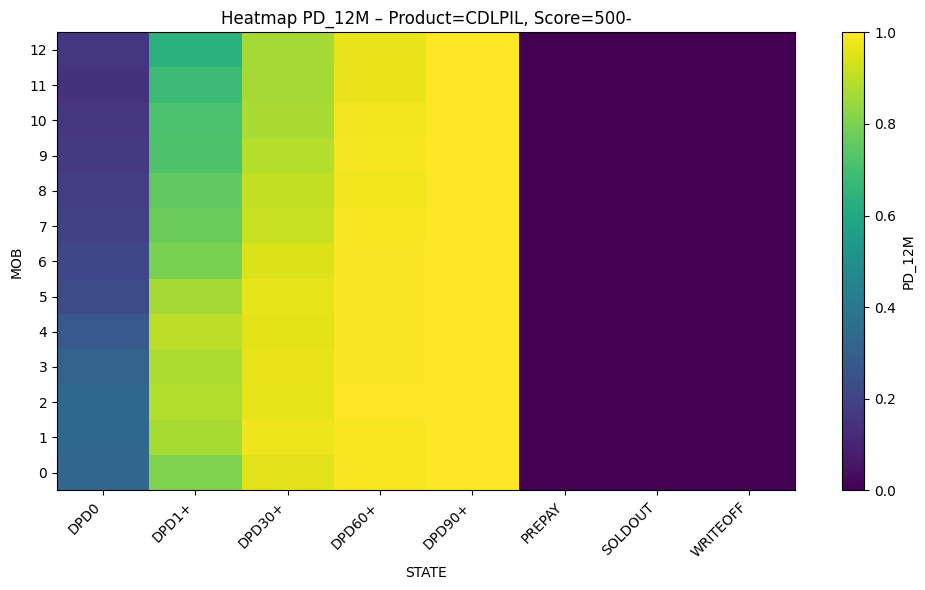

In [31]:
import matplotlib.pyplot as plt
# ============================================================
# 9) HEATMAP PD_12M (MOB × STATE)
# ============================================================

if 'pd_grid' in locals():
    plt.figure(figsize=(10, 6))
    plt.imshow(pd_grid.values, aspect="auto", origin="lower")
    plt.colorbar(label="PD_12M")
    plt.yticks(ticks=range(len(pd_grid.index)), labels=pd_grid.index)
    plt.xticks(ticks=range(len(pd_grid.columns)), labels=pd_grid.columns, rotation=45, ha="right")
    plt.title(f"Heatmap PD_12M – Product={sample_prod}, Score={sample_score}")
    plt.xlabel("STATE")
    plt.ylabel("MOB")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Chưa có pd_grid để vẽ heatmap.")


In [32]:
df_mob_qc.groupby("PRODUCT_TYPE")["IS_FALLBACK"].mean()


PRODUCT_TYPE
CDLPIL    0.0
Name: IS_FALLBACK, dtype: float64

In [33]:
df_mob_qc[df_mob_qc["PRODUCT_TYPE"]=="CDLPIL"]


,PRODUCT_TYPE,RISK_SCORE,MOB,IS_FALLBACK,REASON,ROW_SUM_MIN,ROW_SUM_MAX,P_to_DPD90+_MEAN,P_to_DPD90+_MAX
0,CDLPIL,500-,0,False,,1.0,1.0,0.193439,1.0
1,CDLPIL,500-,1,False,,1.0,1.0,0.190478,1.0
2,CDLPIL,500-,2,False,,1.0,1.0,0.192459,1.0
3,CDLPIL,500-,3,False,,1.0,1.0,0.199008,1.0
4,CDLPIL,500-,4,False,,1.0,1.0,0.197683,1.0
...,...,...,...,...,...,...,...,...,...
139,CDLPIL,OTHERS,19,False,,1.0,1.0,0.193333,1.0
140,CDLPIL,OTHERS,20,False,,1.0,1.0,0.200000,1.0
141,CDLPIL,OTHERS,21,False,,1.0,1.0,0.127410,1.0
142,CDLPIL,OTHERS,22,False,,1.0,1.0,0.108930,1.0


In [34]:
# Kiểm tra xem P_child có bằng parent P không?
prod = "CDLPIL"
score = "500-"

parent_P = parent_fallback[(prod, score)]

for mob, score_block in matrices_by_mob[prod].items():
    P_child = score_block[score]["P"]
    same = (P_child.values == parent_P.values).all()
    print(mob, same)


0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False


In [35]:
(P_child.values == parent_P.values).all()


np.False_

In [36]:
# Kiểm tra keys có trong parent_fallback nhưng không có trong matrices_by_mob
missing_in_matrix = []

for (prod, score) in parent_fallback.keys():
    if prod not in matrices_by_mob:
        missing_in_matrix.append((prod, score))
    else:
        # kiểm tra score tồn tại trong bất kỳ MOB nào
        score_exists = any(score in matrices_by_mob[prod][mob] for mob in matrices_by_mob[prod])
        if not score_exists:
            missing_in_matrix.append((prod, score))

print("➡ Fallback do thiếu (product, score):")
print(missing_in_matrix)


➡ Fallback do thiếu (product, score):
[]


In [37]:
fallback_mob = []

for prod, mob_dict in matrices_by_mob.items():
    for mob, score_dict in mob_dict.items():
        for score, obj in score_dict.items():
            if isinstance(obj, dict) and obj.get("is_fallback", False):
                fallback_mob.append((prod, score, mob, obj["reason"]))

print("➡ Fallback MOB-level (is_fallback=True):")
for r in fallback_mob:
    print(r)


➡ Fallback MOB-level (is_fallback=True):


In [38]:
print("➡ Fallback do MOB không tồn tại:")
for prod, mob_dict in matrices_by_mob.items():
    available_mobs = sorted(mob_dict.keys())
    for test_mob in range(0, max(available_mobs)+1):
        # pick nearest MOB
        le = [m for m in available_mobs if m <= test_mob]
        mob_key = max(le) if le else available_mobs[0]
        if mob_key != test_mob:
            print(prod, "MOB", test_mob, "fallback to MOB", mob_key)


➡ Fallback do MOB không tồn tại:


In [39]:
import numpy as np

print("➡ Fallback mềm (P_child ≈ P_parent):")

tol = 1e-6
for (prod, score), P_parent in parent_fallback.items():
    if prod not in matrices_by_mob:
        continue
    for mob, score_dict in matrices_by_mob[prod].items():
        if score not in score_dict:
            continue

        P_child = score_dict[score]["P"]

        # Kiểm tra tương đồng tuyệt đối
        diff = np.abs(P_child.values - P_parent.values)
        if diff.max() < tol:
            print(f"(prod={prod}, score={score}, mob={mob}) ≈ parent fallback (max diff={diff.max()})")


➡ Fallback mềm (P_child ≈ P_parent):


In [40]:
print("➡ Fallback do missing state (rows all zero before normalize):")

for prod, mob_dict in matrices_by_mob.items():
    for mob, score_dict in mob_dict.items():
        for score, obj in score_dict.items():
            P = obj["P"]
            zero_rows = (P.sum(axis=1) == 0).tolist()
            if any(zero_rows):
                print(prod, score, mob, "zero_rows =", zero_rows)


➡ Fallback do missing state (rows all zero before normalize):


In [41]:
from src.rollrate.lgd_utils import run_lgd_pipeline

lgd_out = run_lgd_pipeline(
    data_path=r"C:/Users/MAFC4709/Python_work/RR_model_ECL/data/LGD2.parquet",
    use_loader=True
)

📦 Loading Parquet from: C:\Users\MAFC4709\Python_work\RR_model_ECL\data\LGD2.parquet
✅ Loaded 944,702 rows from LGD2.parquet
ℹ️ Added default column PRODUCT_TYPE = 'A'
📂 Loaded 944,702 rows.
✔ Preprocessed: 440,297 rows.
🎉 LGD Pipeline Completed!
Output folder: C:\Users\MAFC4709\Python_work\RR_model_ECL_parallel\outputs\LGD


In [22]:
lgd_out

{'df_raw':        MIN_CUTOFF_DATE CUTOFF_DATE_M0    PRODUCT PRODUCT_2  AGREEMENT_ID  \
 0           2023-10-31     2023-10-31  SURROGATE       NTB       4063419   
 1           2024-02-29     2024-02-29        ECL       NTB       4063437   
 2           2024-08-31     2024-08-31     CDLPIL  POS_LOAN       4063479   
 3           2024-02-29     2024-02-29  SURROGATE       NTB       4063488   
 4           2023-08-31     2023-08-31  FAST LOAN       NTB       4064098   
 ...                ...            ...        ...       ...           ...   
 944697      2023-06-30     2023-06-30     Others      None       2873796   
 944698      2023-06-21     2023-06-21     Others      None       2873877   
 944699      2024-01-31     2024-01-31  SURROGATE       NTB       2794797   
 944700      2023-06-21     2023-06-21     Others      None       2794862   
 944701      2023-10-31     2023-10-31  SURROGATE       NTB       2795269   
 
         M0_DPD     M0_POS  M0_STAGE  M6_DPD     M6_POS  ... M12

In [ ]:
df_lgd= lgd_out

In [ ]:
df_lgd

In [ ]:
# ============================================================
# 6. MAP LGD (LGD_BASE → LGD_EFF) & TÍNH ECL_12M
#    - Mục tiêu:
#        + Gắn LGD theo PRODUCT_SEGMENT & MOB_BUCKET
#        + Tính LGD_EFF thực tế cho từng khoản vay
#        + Tính ECL_12M = PD_12M × LGD_EFF × EAD
#    - Đầu vào:
#        + df_current (có PD_12M, MOB, PRODUCT_TYPE)
#        + lgd_base: bảng LGD bạn đã có (PRODUCT_SEGMENT, MOB_BUCKET, LGD_BASE)
#    - Đầu ra:
#        + df_lgd: bảng đầy đủ để báo cáo (detail)
#    - Đóng góp:
#        + Ghép đủ 3 trụ cột PD – LGD – EAD → ECL_12M
# ============================================================

print("\n=== STEP 6: MAP LGD & COMPUTE ECL_12M ===")

# 6.1. Tính MOB_AT_DEFAULT ~ MOB + 6 (giả định sự kiện default trung bình tại 6/12M)
df_current["MOB_AT_DEFAULT"] = (df_current[mob] + 6).astype(int)
df_current["MOB_AT_DEFAULT"] = df_current["MOB_AT_DEFAULT"].clip(lower=0)

# 6.2. Chuẩn hoá LGD base
lgd = lgd_base.copy()
lgd["MOB_BUCKET_MIN"] = lgd["MOB_BUCKET"].str.split("-").str[0].astype(int)
lgd["MOB_BUCKET_MAX"] = lgd["MOB_BUCKET"].str.split("-").str[1].astype(int)

# 6.3. Merge theo PRODUCT_TYPE
df_lgd = df_current.merge(
    lgd,
    left_on="PRODUCT_TYPE",
    right_on="PRODUCT_SEGMENT",
    how="left"
)

# 6.4. Lọc đúng bucket MOB
mask_bucket = (
    (df_lgd["MOB_AT_DEFAULT"] >= df_lgd["MOB_BUCKET_MIN"]) &
    (df_lgd["MOB_AT_DEFAULT"] <= df_lgd["MOB_BUCKET_MAX"])
)
df_lgd = df_lgd[mask_bucket].copy()

# 6.5. LGD_EFF
df_lgd["LGD_EFF"] = df_lgd["LGD_BASE"].fillna(df_lgd["LGD_BASE"].mean())
df_lgd["LGD_EFF"].fillna(0.5, inplace=True)   # fallback cuối

# 6.6. Tính ECL_12M
df_lgd["ECL_12M"] = df_lgd["PD_12M"] * df_lgd["LGD_EFF"] * df_lgd[ead]
df_lgd["ECL_12M"].fillna(0.0, inplace=True)

print("Một vài dòng df_lgd (detail):")
display(df_lgd[[loan, state, mob, "PRODUCT_TYPE", "PD_12M", "LGD_EFF", ead, "ECL_12M"]].head())




In [22]:
# ============================================================
# 7. SUMMARY & EXPORT EXCEL REPORT
#    - Mục tiêu:
#        + Tạo các bảng summary phục vụ báo cáo:
#            * Summary tổng
#            * By Product
#            * By MOB
#            * By Score
#            * By State
#            * By Segment (Product×Score)
#        + Xuất 1 file Excel duy nhất: ECL_Report.xlsx
#    - Đầu vào:
#        + df_lgd (detail)
#    - Đầu ra:
#        + summary, summary_by_* (DataFrame)
#        + file Excel
#    - Đóng góp:
#        + Đây là deliverable cuối cùng cho báo cáo ECL Stage 1
# ============================================================

print("\n=== STEP 7: SUMMARY & EXPORT EXCEL ===")

total_ead = df_lgd[ead].sum()
total_ecl = df_lgd["ECL_12M"].sum()
weighted_pd  = (df_lgd["PD_12M"] * df_lgd[ead]).sum() / total_ead
weighted_lgd = (df_lgd["LGD_EFF"] * df_lgd[ead]).sum() / total_ead

summary = pd.DataFrame({
    "TOTAL_EAD": [total_ead],
    "TOTAL_ECL": [total_ecl],
    "WEIGHTED_PD": [weighted_pd],
    "WEIGHTED_LGD": [weighted_lgd],
    "ECL_RATE": [total_ecl / total_ead],
})

# 7.1. Summary theo PRODUCT
report_by_product = (
    df_lgd.groupby("PRODUCT_TYPE")
    .agg(
        TOTAL_EAD=(ead, "sum"),
        TOTAL_ECL=("ECL_12M", "sum"),
        AVG_PD=("PD_12M", "mean"),
        W_PD=lambda g: (g["PD_12M"] * g[ead]).sum() / g[ead].sum(),
        W_LGD=lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum(),
    )
)

# 7.2. Summary theo MOB
summary_by_mob = (
    df_lgd.groupby(mob)
    .agg(
        TOTAL_EAD=(ead, "sum"),
        TOTAL_ECL=("ECL_12M", "sum"),
        AVG_PD=("PD_12M", "mean"),
        W_PD=lambda g: (g["PD_12M"] * g[ead]).sum() / g[ead].sum(),
        W_LGD=lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum(),
    )
    .reset_index()
)

# 7.3. Summary theo SCORE (nếu có)
score_col = "RISK_SCORE" if "RISK_SCORE" in df_lgd.columns else None
if score_col:
    summary_by_score = (
        df_lgd.groupby(score_col)
        .agg(
            TOTAL_EAD=(ead, "sum"),
            TOTAL_ECL=("ECL_12M", "sum"),
            AVG_PD=("PD_12M", "mean"),
            W_PD=lambda g: (g["PD_12M"] * g[ead]).sum() / g[ead].sum(),
            W_LGD=lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum(),
        )
        .reset_index()
    )
else:
    summary_by_score = pd.DataFrame({"NOTE": ["Không có cột RISK_SCORE"]})

# 7.4. Summary theo STATE_MODEL
summary_by_state = (
    df_lgd.groupby(state)
    .agg(
        TOTAL_EAD=(ead, "sum"),
        TOTAL_ECL=("ECL_12M", "sum"),
        AVG_PD=("PD_12M", "mean"),
        W_PD=lambda g: (g["PD_12M"] * g[ead]).sum() / g[ead].sum(),
        W_LGD=lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum(),
    )
    .reset_index()
)

# 7.5. Summary theo SEGMENT (PRODUCT × SCORE)
if score_col:
    df_lgd["SEGMENT"] = df_lgd["PRODUCT_TYPE"].astype(str) + "_" + df_lgd[score_col].astype(str)
else:
    df_lgd["SEGMENT"] = df_lgd["PRODUCT_TYPE"]

summary_by_segment = (
    df_lgd.groupby("SEGMENT")
    .agg(
        TOTAL_EAD=(ead, "sum"),
        TOTAL_ECL=("ECL_12M", "sum"),
        AVG_PD=("PD_12M", "mean"),
        W_PD=lambda g: (g["PD_12M"] * g[ead]).sum() / g[ead].sum(),
        W_LGD=lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum(),
    )
)

# 7.6. Export Excel
output_file = "ECL_Report.xlsx"
with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    df_lgd.to_excel(writer, sheet_name="Detail", index=False)
    summary.to_excel(writer, sheet_name="Summary", index=False)
    report_by_product.to_excel(writer, sheet_name="By_Product")
    summary_by_mob.to_excel(writer, sheet_name="By_MOB", index=False)
    summary_by_score.to_excel(writer, sheet_name="By_Score", index=False)
    summary_by_state.to_excel(writer, sheet_name="By_State", index=False)
    summary_by_segment.to_excel(writer, sheet_name="By_Segment")

print(f"✅ DONE! ECL report exported to: {output_file}")

# Hiển thị nhanh summary
display(summary)


=== STEP 7: SUMMARY & EXPORT EXCEL ===


TypeError: Must provide 'func' or tuples of '(column, aggfunc).

In [21]:
df_lgd

,CUTOFF_DATE,AGREEMENT_ID,DISBURSAL_DATE,DISBURSAL_AMOUNT,DPD_EOM,RISK_BUCKET,PRINCIPLE_OUTSTANDING,STATUS,MOB,PRODUCT_TYPE,...,EAD_LATEST,PD_12M,MOB_AT_DEFAULT,PRODUCT_SEGMENT,MOB_BUCKET,LGD_BASE,MOB_BUCKET_MIN,MOB_BUCKET_MAX,LGD_EFF,ECL_12M
2,2025-10-01,4951766,2023-10-01,27.82000,148,B5,8.673848,A,24,CDLPIL,...,8.673848,1.000000,30,CDLPIL,25-36,0.881795,25,36,0.881795,7.648560
7,2025-10-01,4952180,2023-10-01,12.25900,638,B7+,5.881104,WRITEOFF,24,CDLPIL,...,5.881104,0.000000,30,CDLPIL,25-36,0.881795,25,36,0.881795,0.000000
12,2025-10-01,4952924,2023-10-01,27.82000,371,B7+,17.229004,WRITEOFF,24,CDLPIL,...,17.229004,0.000000,30,CDLPIL,25-36,0.881795,25,36,0.881795,0.000000
17,2025-10-01,4953345,2023-10-01,31.98000,30,B1,0.258280,A,24,CDLPIL,...,0.258280,0.293499,30,CDLPIL,25-36,0.881795,25,36,0.881795,0.066844
22,2025-10-01,4953354,2023-10-01,12.84000,634,B7+,9.599204,WRITEOFF,24,CDLPIL,...,9.599204,0.000000,30,CDLPIL,25-36,0.881795,25,36,0.881795,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764540,2025-10-01,7054617,2025-10-01,17.05600,0,B0,17.056000,A,0,CDLPIL,...,17.056000,0.208909,6,CDLPIL,0-6,0.922378,0,6,0.922378,3.286578
2764545,2025-10-01,7054619,2025-10-01,23.00000,0,B0,23.000000,A,0,CDLPIL,...,23.000000,0.039378,6,CDLPIL,0-6,0.922378,0,6,0.922378,0.835385
2764550,2025-10-01,7054620,2025-10-01,2.66500,0,B0,2.665000,A,0,CDLPIL,...,2.665000,0.120380,6,CDLPIL,0-6,0.922378,0,6,0.922378,0.295911
2764555,2025-10-01,7054622,2025-10-01,11.91255,0,B0,11.912550,A,0,CDLPIL,...,11.912550,0.328584,6,CDLPIL,0-6,0.922378,0,6,0.922378,3.610438


In [19]:
# ============================================================
# 7. SUMMARY & EXPORT EXCEL REPORT
#    - Mục tiêu:
#        + Tạo các bảng summary phục vụ báo cáo:
#            * Summary tổng
#            * By Product
#            * By MOB
#            * By Score
#            * By State
#            * By Segment (Product×Score)
#        + Xuất 1 file Excel duy nhất: ECL_Report.xlsx
#    - Đầu vào:
#        + df_lgd (detail)
#    - Đầu ra:
#        + summary, summary_by_* (DataFrame)
#        + file Excel
#    - Đóng góp:
#        + Đây là deliverable cuối cùng cho báo cáo ECL Stage 1
# ============================================================

print("\n=== STEP 7: SUMMARY & EXPORT EXCEL ===")

total_ead = df_lgd[ead].sum()
total_ecl = df_lgd["ECL_12M"].sum()
weighted_pd  = (df_lgd["PD_12M"] * df_lgd[ead]).sum() / total_ead
weighted_lgd = (df_lgd["LGD_EFF"] * df_lgd[ead]).sum() / total_ead

summary = pd.DataFrame({
    "TOTAL_EAD": [total_ead],
    "TOTAL_ECL": [total_ecl],
    "WEIGHTED_PD": [weighted_pd],
    "WEIGHTED_LGD": [weighted_lgd],
    "ECL_RATE": [total_ecl / total_ead],
})

# 7.1. Summary theo PRODUCT
# report_by_product = (
#     df_lgd.groupby("PRODUCT_TYPE")
#     .agg(
#         TOTAL_EAD=(ead, "sum"),
#         TOTAL_ECL=("ECL_12M", "sum"),
#         AVG_PD=("PD_12M", "mean"),
#         W_PD=lambda g: (g["PD_12M"] * g[ead]).sum() / g[ead].sum(),
#         W_LGD=lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum(),
#     )
# )

# 7.2. Summary theo MOB
# summary_by_mob = (
#     df_lgd.groupby(mob)
#     .agg(
#         TOTAL_EAD=(ead, "sum"),
#         TOTAL_ECL=("ECL_12M", "sum"),
#         AVG_PD=("PD_12M", "mean"),
#         W_PD=lambda g: (g["PD_12M"] * g[ead]).sum() / g[ead].sum(),
#         W_LGD=lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum(),
#     )
#     .reset_index()
# )

# 7.3. Summary theo SCORE (nếu có)
# score_col = "RISK_SCORE" if "RISK_SCORE" in df_lgd.columns else None
# if score_col:
#     summary_by_score = (
#         df_lgd.groupby(score_col)
#         .agg(
#             TOTAL_EAD=(ead, "sum"),
#             TOTAL_ECL=("ECL_12M", "sum"),
#             AVG_PD=("PD_12M", "mean"),
#             W_PD=lambda g: (g["PD_12M"] * g[ead]).sum() / g[ead].sum(),
#             W_LGD=lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum(),
#         )
#         .reset_index()
#     )
# else:
#     summary_by_score = pd.DataFrame({"NOTE": ["Không có cột RISK_SCORE"]})

# 7.4. Summary theo STATE_MODEL
# summary_by_state = (
#     df_lgd.groupby(state)
#     .agg(
#         TOTAL_EAD=(ead, "sum"),
#         TOTAL_ECL=("ECL_12M", "sum"),
#         AVG_PD=("PD_12M", "mean"),
#         W_PD=lambda g: (g["PD_12M"] * g[ead]).sum() / g[ead].sum(),
#         W_LGD=lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum(),
#     )
#     .reset_index()
# )

# 7.5. Summary theo SEGMENT (PRODUCT × SCORE)
# if score_col:
#     df_lgd["SEGMENT"] = df_lgd["PRODUCT_TYPE"].astype(str) + "_" + df_lgd[score_col].astype(str)
# else:
#     df_lgd["SEGMENT"] = df_lgd["PRODUCT_TYPE"]

# summary_by_segment = (
#     df_lgd.groupby("SEGMENT")
#     .agg(
#         TOTAL_EAD=(ead, "sum"),
#         TOTAL_ECL=("ECL_12M", "sum"),
#         AVG_PD=("PD_12M", "mean"),
#         W_PD=lambda g: (g["PD_12M"] * g[ead]).sum() / g[ead].sum(),
#         W_LGD=lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum(),
#     )
# )

# 7.6. Export Excel
output_file = "ECL_Report.xlsx"
with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    df_lgd.to_excel(writer, sheet_name="Detail", index=False)
    summary.to_excel(writer, sheet_name="Summary", index=False)
    # report_by_product.to_excel(writer, sheet_name="By_Product")
    # summary_by_mob.to_excel(writer, sheet_name="By_MOB", index=False)
    # summary_by_score.to_excel(writer, sheet_name="By_Score", index=False)
    # summary_by_state.to_excel(writer, sheet_name="By_State", index=False)
    # summary_by_segment.to_excel(writer, sheet_name="By_Segment")

print(f"✅ DONE! ECL report exported to: {output_file}")

# Hiển thị nhanh summary
display(summary)


=== STEP 7: SUMMARY & EXPORT EXCEL ===
✅ DONE! ECL report exported to: ECL_Report.xlsx


,TOTAL_EAD,TOTAL_ECL,WEIGHTED_PD,WEIGHTED_LGD,ECL_RATE
0,5.237339e+06,1.409662e+06,0.335923,0.812968,0.269156


In [42]:
df_trans = df
print("=== CHECK 1: số lượng dòng total ===")
print(len(df_trans))

print("=== CHECK 2: số loan unique ===")
print(df_trans[CFG["loan"]].nunique())

print("=== CHECK 3: MOB min/max ===")
print(df_trans[CFG["mob"]].min(), df_trans[CFG["mob"]].max())

print("=== CHECK 4: có MOB âm hoặc null không ===")
print(df_trans[CFG["mob"]].isna().sum(), (df_trans[CFG["mob"]] < 0).sum())

print("=== CHECK 5: state null ===")
print(df_trans[CFG["state"]].isna().sum())


=== CHECK 1: số lượng dòng total ===
18219537
=== CHECK 2: số loan unique ===
1364603
=== CHECK 3: MOB min/max ===
0 24
=== CHECK 4: có MOB âm hoặc null không ===
0 0
=== CHECK 5: state null ===
0


In [43]:
print("=== CHECK 6: panel continuity ===")

df_srt = df_trans.sort_values([CFG["loan"], CFG["mob"]])
df_srt["mob_next"] = df_srt.groupby(CFG["loan"])[CFG["mob"]].shift(-1)
df_srt["delta"] = df_srt["mob_next"] - df_srt[CFG["mob"]]

# hợp lệ = delta == 1 hoặc mob cuối = NaN
invalid = df_srt[(df_srt["delta"].notna()) & (df_srt["delta"] != 1)]
print("Số dòng không liên tục MOB→MOB+1:", len(invalid))
display(invalid.head(20))


=== CHECK 6: panel continuity ===
Số dòng không liên tục MOB→MOB+1: 0


,CUTOFF_DATE,AGREEMENT_ID,DISBURSAL_DATE,DISBURSAL_AMOUNT,DPD_EOM,RISK_BUCKET,PRINCIPLE_OUTSTANDING,STATUS,MOB,PRODUCT_TYPE,STATE_MODEL,RISK_SCORE,mob_next,delta


In [44]:
print("=== CHECK 7: DPD distribution theo MOB ===")
dpd_dist = (
    df_trans.groupby(CFG["mob"])[CFG["state"]]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)
display(dpd_dist)


=== CHECK 7: DPD distribution theo MOB ===


STATE_MODEL,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,PREPAY,WRITEOFF
MOB,,,,,,,
0,0.998428,0.001572,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.966249,0.019734,0.000745,0.000000,0.000000,0.013270,0.000002
2,0.934910,0.030087,0.013352,0.000719,0.000000,0.020925,0.000007
3,0.903861,0.032573,0.020884,0.012142,0.000917,0.029613,0.000011
4,0.858279,0.046404,0.022420,0.018133,0.013161,0.041571,0.000033
5,0.779971,0.043156,0.034655,0.019134,0.030821,0.092207,0.000056
6,0.460666,0.038246,0.030099,0.029662,0.049034,0.392208,0.000085
7,0.433273,0.023612,0.026421,0.023773,0.076880,0.415625,0.000417
8,0.392585,0.022384,0.016322,0.020778,0.096482,0.450058,0.001391


In [45]:
print("=== CHECK 8: số lượng loan theo orig_date ===")
display(df_trans.groupby(CFG["orig_date"])[CFG["loan"]].nunique())


=== CHECK 8: số lượng loan theo orig_date ===


DISBURSAL_DATE
2023-01-01    20266
2023-02-01    14250
2023-03-01    19723
2023-04-01    19673
2023-05-01    20971
2023-06-01    19377
2023-07-01    21634
2023-08-01    23247
2023-09-01    25383
2023-10-01    28442
2023-11-01    27326
2023-12-01    29236
2024-01-01    37465
2024-02-01    29333
2024-03-01    31726
2024-04-01    32889
2024-05-01    36575
2024-06-01    38785
2024-07-01    44397
2024-08-01    48987
2024-09-01    55496
2024-10-01    60608
2024-11-01    59775
2024-12-01    66370
2025-01-01    70522
2025-02-01    50671
2025-03-01    57311
2025-04-01    55434
2025-05-01    53251
2025-06-01    52542
2025-07-01    52182
2025-08-01    51823
2025-09-01    54167
2025-10-01    54766
Name: AGREEMENT_ID, dtype: int64

In [46]:
print("=== CHECK 9: EAD null hoặc âm ===")
ead_col = CFG["ead"]
print("Null:", df_trans[ead_col].isna().sum())
print("Âm:", (df_trans[ead_col] < 0).sum())

print("EAD describe:")
display(df_trans[ead_col].describe())


=== CHECK 9: EAD null hoặc âm ===
Null: 0
Âm: 0
EAD describe:


count    1.821954e+07
mean     5.170453e+00
std      6.501932e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.638915e+00
75%      8.597208e+00
max      7.000000e+01
Name: PRINCIPLE_OUTSTANDING, dtype: float64

In [47]:
print("=== CHECK 10: product null hoặc bất thường ===")
print(df_trans["PRODUCT_TYPE"].isna().sum())
print(df_trans["PRODUCT_TYPE"].value_counts())


=== CHECK 10: product null hoặc bất thường ===
0
PRODUCT_TYPE
CDLPIL    18219537
Name: count, dtype: int64


In [48]:
print("=== CHECK 11: RISK_SCORE null hoặc mapping sai ===")
print(df_trans["RISK_SCORE"].isna().sum())
print(df_trans["RISK_SCORE"].value_counts())


=== CHECK 11: RISK_SCORE null hoặc mapping sai ===
0
RISK_SCORE
650+      3895799
OTHERS    3817401
600-      2834067
650-      2752525
500-      2492805
550-      2426940
Name: count, dtype: int64


In [49]:
print("=== CHECK 12: duplicate loan–mob ===")

dups = (
    df_trans.groupby([CFG["loan"], CFG["mob"]])
    .size()
    .reset_index(name="cnt")
)
display(dups[dups["cnt"] > 1].head(20))

print("Số trường hợp duplicate:", len(dups[dups["cnt"] > 1]))


=== CHECK 12: duplicate loan–mob ===


,AGREEMENT_ID,MOB,cnt


Số trường hợp duplicate: 0


In [50]:
print("=== CHECK 13: check t→t+1 movement consistency ===")

df_srt = df_srt.sort_values([CFG["loan"], CFG["mob"]])
df_srt["state_next"] = df_srt.groupby(CFG["loan"])[CFG["state"]].shift(-1)

# Kiểm tra state bị mất hoặc chuyển đến state không hợp lệ
invalid_state = df_srt[(df_srt["mob_next"].notna()) & (df_srt["state_next"].isna())]
print("Số dòng state_next null:", len(invalid_state))
display(invalid_state.head(20))


=== CHECK 13: check t→t+1 movement consistency ===
Số dòng state_next null: 0


,CUTOFF_DATE,AGREEMENT_ID,DISBURSAL_DATE,DISBURSAL_AMOUNT,DPD_EOM,RISK_BUCKET,PRINCIPLE_OUTSTANDING,STATUS,MOB,PRODUCT_TYPE,STATE_MODEL,RISK_SCORE,mob_next,delta,state_next


In [51]:
print("=== CHECK 14: state duy nhất trong dataset ===")
states_in_data = sorted(df_trans[CFG["state"]].dropna().unique())
print(states_in_data)

print("STATE_SPACE từ engine:", STATE_SPACE)


=== CHECK 14: state duy nhất trong dataset ===
['DPD0', 'DPD1+', 'DPD30+', 'DPD60+', 'DPD90+', 'PREPAY', 'WRITEOFF']
STATE_SPACE từ engine: ['DPD0', 'DPD1+', 'DPD30+', 'DPD60+', 'DPD90+', 'PREPAY', 'WRITEOFF', 'SOLDOUT']


In [55]:
print("=== CHECK 15: số lượng cặp theo MOB ===")

pairs = df_trans.sort_values([CFG["loan"], CFG["mob"]])
pairs["mob_next"] = pairs.groupby(CFG["loan"])[CFG["mob"]].shift(-1)
valid_pairs = pairs[pairs["mob_next"] - pairs[CFG["mob"]] == 1]

display(valid_pairs.groupby("MOB")[CFG["loan"]].count())


=== CHECK 15: số lượng cặp theo MOB ===


MOB
0     1307475
1     1253447
2     1201766
3     1149719
4     1097328
5     1044249
6      988930
7      931800
8      881226
9      810769
10     744772
11     684997
12     624389
13     568893
14     519906
15     475509
16     436724
17     400310
18     367553
19     335974
20     306641
21     269336
22     240255
23     212966
Name: AGREEMENT_ID, dtype: int64

In [56]:
print("=== CHECK 16: tỷ lệ delinquency tại MOB0 ===")

display(
    df_trans[df_trans[CFG["mob"]]==0][CFG["state"]]
    .value_counts(normalize=True)
)


=== CHECK 16: tỷ lệ delinquency tại MOB0 ===


STATE_MODEL
DPD0     0.998428
DPD1+    0.001572
Name: proportion, dtype: float64

In [57]:
# import pandas as pd

# # Giả sử DataFrame của bạn tên là df
# df.to_parquet("output.parquet", compression="snappy", index=False)


KeyboardInterrupt: 

In [58]:
fallback_summary = []

for prod in matrices_by_mob:
    for mob in matrices_by_mob[prod]:
        for score in matrices_by_mob[prod][mob]:
            obj = matrices_by_mob[prod][mob][score]
            if obj["is_fallback"]:
                fallback_summary.append((prod, score, mob, obj["reason"]))

pd.DataFrame(fallback_summary, columns=["PRODUCT","SCORE","MOB","REASON"])


,PRODUCT,SCORE,MOB,REASON


In [63]:
df[df["STATE_MODEL"] == "DPD1+"][["STATE_MODEL","POS"]].describe()
df["STATE_MODEL"].value_counts()


KeyError: "['POS'] not in index"

In [66]:
prod = "CDLPIL"     # đổi theo bạn
score = "500-"
mob = 2             # hoặc 1–3

mat = matrices_by_mob[prod][mob][score]["P"]
mat.loc["DPD1+"]


state_t1
DPD0        0.093696
DPD1+       0.169863
DPD30+      0.722861
DPD60+      0.006566
DPD90+      0.000000
DPD120+     0.000000
DPD180+     0.000000
PREPAY      0.007014
WRITEOFF    0.000000
SOLDOUT     0.000000
Name: DPD1+, dtype: float64

In [70]:
PD_12M, path, info = compute_forward_pd_one_record(
    current_state="DPD1+",
    current_mob=2,          # ví dụ 3
    product="CDLPIL",
    score="500-",
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    horizon=12,
)

print("PD_12M from DPD1+:", PD_12M)
print("Path distribution by month:")
print(path)


PD_12M from DPD1+: 0.8832524239214529
Path distribution by month:
[0.0, 0.025358462594618443, 0.5818596524977735, 0.15963330029719824, 0.0657607003103805, 0.02206175111464781, 0.00844846186283732, 0.005889447307515838, 0.004470398783813834, 0.003554655102237403, 0.0030671360962304384, 0.0031484579541994906]


In [73]:
from src.rollrate.transition import make_pairs, compute_transition_from_pairs

pairs_all = make_pairs(df)   # df_raw lifecycle đầy đủ
P_global = compute_transition_from_pairs(
    pair_slice=pairs_all,
    value_col="ead_t",       # hoặc "__COUNT__" nếu muốn count-based
    parent_P=None,
    zero_row_policy="identity",
    alpha_smooth=0.0,
)

P_global.loc["DPD1+"]   # hoặc B1 tuỳ mapping


⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']


state_t1
DPD0        0.099129
DPD1+       0.205781
DPD30+      0.668707
DPD60+      0.006785
DPD90+      0.000004
PREPAY      0.019595
WRITEOFF    0.000000
SOLDOUT     0.000000
Name: DPD1+, dtype: float64

In [76]:
pairs = make_pairs(df)

states_t  = set(pairs["state_t"].dropna().unique())
states_t1 = set(pairs["state_t1"].dropna().unique())

unknown_in_pairs = (states_t | states_t1) - canonical
print("Unknown states in pairs:", unknown_in_pairs)


Unknown states in pairs: set()


In [77]:
import pandas as pd
import numpy as np

# ============================================================
# 1) TẠO Pairs một lần
# ============================================================
pairs = make_pairs(df)

all_results = []

# ============================================================
# 2) LOOP QUA product × score × mob
# ============================================================
for (prod, score), grp_ps in pairs.groupby(["product_t", "score_t"]):

    prod_str  = str(prod)
    score_str = str(score)

    # Parent matrix
    P_parent = parent_fallback.get((prod_str, score_str))

    for mob, grp_mob in grp_ps.groupby("mob_t"):

        mob_int = int(mob)

        # ----------------------------------------------------
        # A) Ma trận đếm (chưa normalize)
        # ----------------------------------------------------
        mat_counts = (
            pd.crosstab(
                grp_mob["state_t"],
                grp_mob["state_t1"],
                values=grp_mob["ead_t"],
                aggfunc="sum",
                dropna=False
            )
            .reindex(index=STATE_SPACE, columns=STATE_SPACE, fill_value=0.0)
        )

        # State không có quan sát
        zero_rows = mat_counts.index[mat_counts.sum(axis=1) == 0].tolist()

        # ----------------------------------------------------
        # B) Check fallback info trong matrices_by_mob
        # ----------------------------------------------------
        mob_info = matrices_by_mob.get(prod_str, {}).get(mob_int, {}).get(score_str, None)

        if mob_info is None:
            is_fallback = None
            reason = "No matrix found"
        else:
            is_fallback = mob_info["is_fallback"]
            reason = mob_info["reason"]

        all_results.append({
            "PRODUCT": prod_str,
            "SCORE": score_str,
            "MOB": mob_int,
            "N_PAIRS": len(grp_mob),
            "TOTAL_EAD": grp_mob["ead_t"].sum(),
            "ZERO_ROW_STATES": ",".join(zero_rows),
            "N_ZERO": len(zero_rows),
            "IS_FALLBACK": is_fallback,
            "REASON": reason
        })

# ============================================================
# 3) Xuất bảng tổng hợp đầy đủ
# ============================================================
df_check = pd.DataFrame(all_results)
df_check = df_check.sort_values(["PRODUCT","SCORE","MOB"]).reset_index(drop=True)

df_check[IS_FALLBACK]



,PRODUCT,SCORE,MOB,N_PAIRS,TOTAL_EAD,ZERO_ROW_STATES,N_ZERO,IS_FALLBACK,REASON
0,CDLPIL,500-,0,164829,1.451992e+06,"DPD30+,DPD60+,DPD90+,PREPAY,WRITEOFF,SOLDOUT",6,False,
1,CDLPIL,500-,1,162871,1.361011e+06,"DPD60+,DPD90+,PREPAY,WRITEOFF,SOLDOUT",5,False,
2,CDLPIL,500-,2,158613,1.267165e+06,"DPD90+,PREPAY,WRITEOFF,SOLDOUT",4,False,
3,CDLPIL,500-,3,152553,1.170268e+06,"PREPAY,WRITEOFF,SOLDOUT",3,False,
4,CDLPIL,500-,4,145527,1.084413e+06,"PREPAY,SOLDOUT",2,False,
...,...,...,...,...,...,...,...,...,...
139,CDLPIL,OTHERS,19,60139,1.599708e+04,"DPD1+,DPD60+,PREPAY,SOLDOUT",4,False,
140,CDLPIL,OTHERS,20,56559,1.609527e+04,"PREPAY,SOLDOUT",2,False,
141,CDLPIL,OTHERS,21,51188,1.510940e+04,"PREPAY,SOLDOUT",2,False,
142,CDLPIL,OTHERS,22,43831,1.347454e+04,"PREPAY,SOLDOUT",2,False,


In [79]:
df_check[df_check["IS_FALLBACK"] == "True"]

,PRODUCT,SCORE,MOB,N_PAIRS,TOTAL_EAD,ZERO_ROW_STATES,N_ZERO,IS_FALLBACK,REASON


In [80]:
df_fb = []

for prod, mob_dict in matrices_by_mob.items():
    for mob, score_dict in mob_dict.items():
        for score, obj in score_dict.items():
            if obj["is_fallback"]:
                df_fb.append([prod, score, mob, obj["reason"]])

pd.DataFrame(df_fb, columns=["PRODUCT", "SCORE", "MOB", "REASON"])


,PRODUCT,SCORE,MOB,REASON


In [82]:
df[df[CFG["state"]] == "PREPAY"][CFG["ead"]].describe()


count    7555845.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: PRINCIPLE_OUTSTANDING, dtype: float64

In [83]:
rows = []

for prod, mob_dict in matrices_by_mob.items():
    for mob, score_dict in mob_dict.items():
        for score, obj in score_dict.items():
            rows.append({
                "PRODUCT": prod,
                "SCORE": score,
                "MOB": mob,
                "IS_FALLBACK": obj["is_fallback"]
            })

df_fb = pd.DataFrame(rows)
summary = df_fb.groupby(["PRODUCT","SCORE"])["IS_FALLBACK"].mean().reset_index()
summary.rename(columns={"IS_FALLBACK":"FALLBACK_RATIO"}, inplace=True)
summary


,PRODUCT,SCORE,FALLBACK_RATIO
0,CDLPIL,500-,0.0
1,CDLPIL,550-,0.0
2,CDLPIL,600-,0.0
3,CDLPIL,650+,0.0
4,CDLPIL,650-,0.0
5,CDLPIL,OTHERS,0.0


In [84]:
df_fb[df_fb["MOB"] <= 6].groupby("MOB")["IS_FALLBACK"].mean()


MOB
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
Name: IS_FALLBACK, dtype: float64

In [85]:
df_fb.groupby(["PRODUCT","SCORE"])["IS_FALLBACK"].mean()


PRODUCT  SCORE 
CDLPIL   500-      0.0
         550-      0.0
         600-      0.0
         650+      0.0
         650-      0.0
         OTHERS    0.0
Name: IS_FALLBACK, dtype: float64

In [86]:
df_fb.groupby(["PRODUCT","SCORE"])["IS_FALLBACK"].mean()


PRODUCT  SCORE 
CDLPIL   500-      0.0
         550-      0.0
         600-      0.0
         650+      0.0
         650-      0.0
         OTHERS    0.0
Name: IS_FALLBACK, dtype: float64

In [88]:
df.groupby(CFG["state"]).size()


STATE_MODEL
DPD0        8565511
DPD1+        341540
DPD30+       225358
DPD60+       173272
DPD90+       916870
PREPAY      7555845
WRITEOFF     441141
dtype: int64

In [89]:
prod = "CDLPIL"  # đổi theo bạn
score = "500-"

P_parent = parent_fallback[(prod, score)]
P_parent.loc["DPD1+"]


state_t1
DPD0        0.086027
DPD1+       0.199158
DPD30+      0.695839
DPD60+      0.007003
DPD90+      0.000007
DPD120+     0.000000
DPD180+     0.000000
PREPAY      0.011965
WRITEOFF    0.000000
SOLDOUT     0.000000
Name: DPD1+, dtype: float64

In [90]:
rows=[]
for prod, mob_dict in matrices_by_mob.items():
    for mob, score_dict in mob_dict.items():
        for score, obj in score_dict.items():
            rows.append([prod, score, mob, obj["is_fallback"], obj["reason"]])

df_fb = pd.DataFrame(rows, columns=["PRODUCT","SCORE","MOB","IS_FALLBACK","REASON"])
df_fb


,PRODUCT,SCORE,MOB,IS_FALLBACK,REASON
0,CDLPIL,500-,0,False,
1,CDLPIL,550-,0,False,
2,CDLPIL,600-,0,False,
3,CDLPIL,650+,0,False,
4,CDLPIL,650-,0,False,
...,...,...,...,...,...
139,CDLPIL,550-,23,False,
140,CDLPIL,600-,23,False,
141,CDLPIL,650+,23,False,
142,CDLPIL,650-,23,False,


In [91]:
pairs_all["__COUNT__"] = 1.0

full_mat_count = compute_transition_from_pairs(
    pairs_all,
    value_col="__COUNT__"
)

full_mat_count.loc["DPD1+"]


⚠️ Có 1 hàng có tổng weight = 0: ['SOLDOUT']


state_t1
DPD0        0.102906
DPD1+       0.205372
DPD30+      0.619065
DPD60+      0.006153
DPD90+      0.000005
PREPAY      0.066499
WRITEOFF    0.000000
SOLDOUT     0.000000
Name: DPD1+, dtype: float64

In [94]:
# COUNT-based full history
pairs_all = make_pairs(df)
pairs_all["__COUNT__"] = 1.0

P_full_count = compute_transition_from_pairs(pairs_all, value_col="__COUNT__")
print(P_full_count.loc["DPD1+"])


⚠️ Có 1 hàng có tổng weight = 0: ['SOLDOUT']
state_t1
DPD0        0.102906
DPD1+       0.205372
DPD30+      0.619065
DPD60+      0.006153
DPD90+      0.000005
PREPAY      0.066499
WRITEOFF    0.000000
SOLDOUT     0.000000
Name: DPD1+, dtype: float64


In [95]:
# EAD-based 24m
print(P_parent.loc["DPD1+"])


state_t1
DPD0        0.086027
DPD1+       0.199158
DPD30+      0.695839
DPD60+      0.007003
DPD90+      0.000007
DPD120+     0.000000
DPD180+     0.000000
PREPAY      0.011965
WRITEOFF    0.000000
SOLDOUT     0.000000
Name: DPD1+, dtype: float64


In [96]:
pairs = make_pairs(df)

pairs_1p = pairs[pairs["state_t"]=="DPD1+"]

pairs_1p["state_t1"].value_counts(normalize=True)


state_t1
DPD30+    0.619065
DPD1+     0.205372
DPD0      0.102906
PREPAY    0.066499
DPD60+    0.006153
DPD90+    0.000005
Name: proportion, dtype: float64

In [97]:
for mob in sorted(matrices_by_mob["CDLPIL"].keys()):
    print(mob, matrices_by_mob["CDLPIL"][mob]["500-"]["is_fallback"])


0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False


In [98]:
pairs_1p["ead_t"].describe()


count    202515.000000
mean          5.613876
std           4.633672
min           0.001446
25%           1.883919
50%           4.259446
75%           8.317186
max          40.473075
Name: ead_t, dtype: float64

In [100]:
work = df.copy()
month_idx = work["CUTOFF_DATE"].dt.to_period("M").astype(int)
age_raw = month_idx.max() - month_idx
age_raw.describe()


count    1.821954e+07
mean     9.610416e+00
std      7.462903e+00
min      0.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      3.300000e+01
Name: CUTOFF_DATE, dtype: float64

In [102]:
# In các mob đang dùng trong PD_12M
df_current["MOB"].describe()


count    552913.000000
mean          5.614422
std           4.310066
min           0.000000
25%           2.000000
50%           5.000000
75%           9.000000
max          24.000000
Name: MOB, dtype: float64

In [103]:
# Xem các MOB có trong matrices
sorted(matrices_by_mob[prod][score].keys())


KeyError: 'OTHERS'

In [104]:
for t in range(1,13):
    mob_t = current_mob + (t-1)
    P_t = _get_P_for_mob(prod, score, mob_t, matrices_by_mob, parent_fallback, STATE_SPACE)
    print(t, mob_t, "→ parent?" , P_t is parent_fallback.get((prod,score)))


NameError: name 'current_mob' is not defined

In [107]:
PD_12M, mPD, path = compute_forward_pd_one_record(
    current_state="DPD0", 
    current_mob=0,
    product="CDLPIL",
    score="500-",
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    debug=True
)



=== Tháng t=1, MOB_t=0 ===
π (before):
DPD0        1.0
DPD1+       0.0
DPD30+      0.0
DPD60+      0.0
DPD90+      0.0
PREPAY      0.0
WRITEOFF    0.0
SOLDOUT     0.0
dtype: float64
Row default (sau bước): DPD90+ → 0.0
inc_default_t=0.000000

=== Tháng t=2, MOB_t=1 ===
π (before):
state_t1
DPD0        0.954366
DPD1+       0.030655
DPD30+      0.000000
DPD60+      0.000000
DPD90+      0.000000
PREPAY      0.014979
WRITEOFF    0.000000
SOLDOUT     0.000000
dtype: float64
Row default (sau bước): DPD90+ → 0.0
inc_default_t=0.000000

=== Tháng t=3, MOB_t=2 ===
π (before):
state_t1
DPD0        0.903268
DPD1+       0.051893
DPD30+      0.021179
DPD60+      0.000105
DPD90+      0.000000
PREPAY      0.023554
WRITEOFF    0.000000
SOLDOUT     0.000000
dtype: float64
Row default (sau bước): DPD90+ → 0.0004885480492929869
inc_default_t=0.000489

=== Tháng t=4, MOB_t=3 ===
π (before):
state_t1
DPD0        0.849783
DPD1+       0.060269
DPD30+      0.038666
DPD60+      0.018870
DPD90+      0.000489
P

In [110]:
from src.rollrate.pd_forward import _resolve_segment_keys

for row in df_current.sample(20).itertuples():
    print(row.PRODUCT_TYPE, row.RISK_SCORE,
          _resolve_segment_keys(str(row.PRODUCT_TYPE),
                                str(row.RISK_SCORE),
                                matrices_by_mob,
                                parent_fallback))


CDLPIL 600- ('CDLPIL', '600-')
CDLPIL 650- ('CDLPIL', '650-')
CDLPIL 500- ('CDLPIL', '500-')
CDLPIL 600- ('CDLPIL', '600-')
CDLPIL 600- ('CDLPIL', '600-')
CDLPIL OTHERS ('CDLPIL', 'OTHERS')
CDLPIL OTHERS ('CDLPIL', 'OTHERS')
CDLPIL OTHERS ('CDLPIL', 'OTHERS')
CDLPIL 650- ('CDLPIL', '650-')
CDLPIL 500- ('CDLPIL', '500-')
CDLPIL 650+ ('CDLPIL', '650+')
CDLPIL OTHERS ('CDLPIL', 'OTHERS')
CDLPIL OTHERS ('CDLPIL', 'OTHERS')
CDLPIL OTHERS ('CDLPIL', 'OTHERS')
CDLPIL 600- ('CDLPIL', '600-')
CDLPIL 500- ('CDLPIL', '500-')
CDLPIL 650+ ('CDLPIL', '650+')
CDLPIL 650+ ('CDLPIL', '650+')
CDLPIL 650+ ('CDLPIL', '650+')
CDLPIL OTHERS ('CDLPIL', 'OTHERS')


In [109]:
state="DPD1+"; mob=1; prod="CDLPIL"; score="500-"

for t in range(1,13):
    mob_t = mob + (t-1)
    P_t = _get_P_for_mob(prod, score, mob_t,
                         matrices_by_mob, parent_fallback, STATE_SPACE)
    print(f"MOB {mob_t} → lấy ma trận của MOB =", 
          [m for m in matrices_by_mob[prod].keys() if m<=mob_t][-1],
          " | is parent:", P_t is parent_fallback.get((prod,score)))


NameError: name '_get_P_for_mob' is not defined

In [115]:
import sys
sys.path.append("/mnt/data")   # thêm đường dẫn chứa file

from src.rollrate.pd_forward import (
    _resolve_segment_keys,
    _get_P_for_mob,
    compute_forward_pd_one_record,
    DEFAULT_STATE,
    STATE_SPACE
)


In [116]:
state="DPD1+"; mob=1; prod="CDLPIL"; score="500-"

for t in range(1,13):
    mob_t = mob + (t-1)
    P_t = _get_P_for_mob(prod, score, mob_t,
                         matrices_by_mob, parent_fallback, STATE_SPACE)
    print(f"MOB {mob_t} → lấy ma trận của MOB =", 
          [m for m in matrices_by_mob[prod].keys() if m<=mob_t][-1],
          " | is parent:", P_t is parent_fallback.get((prod,score)))


MOB 1 → lấy ma trận của MOB = 1  | is parent: False
MOB 2 → lấy ma trận của MOB = 2  | is parent: False
MOB 3 → lấy ma trận của MOB = 3  | is parent: False
MOB 4 → lấy ma trận của MOB = 4  | is parent: False
MOB 5 → lấy ma trận của MOB = 5  | is parent: False
MOB 6 → lấy ma trận của MOB = 6  | is parent: False
MOB 7 → lấy ma trận của MOB = 7  | is parent: False
MOB 8 → lấy ma trận của MOB = 8  | is parent: False
MOB 9 → lấy ma trận của MOB = 9  | is parent: False
MOB 10 → lấy ma trận của MOB = 10  | is parent: False
MOB 11 → lấy ma trận của MOB = 11  | is parent: False
MOB 12 → lấy ma trận của MOB = 12  | is parent: False


In [117]:
P_MOB3.loc["DPD60+"]   # ma trận tháng 3
P_MOB2.loc["DPD30+"]
P_MOB1.loc["DPD1+"]


NameError: name 'P_MOB3' is not defined

In [20]:
K_FACTOR(product,score)


NameError: name 'K_FACTOR' is not defined

In [21]:
P0 = calib_matrices_by_mob["CDLPIL"][0]["500-"]["P"]
P0.loc["DPD0"]


state_t1
DPD0        0.954366
DPD1+       0.030655
DPD30+      0.000000
DPD60+      0.000000
DPD90+      0.000000
PREPAY      0.014979
WRITEOFF    0.000000
SOLDOUT     0.000000
Name: DPD0, dtype: float64

In [22]:
for mob in range(0,5):
    print("MOB =", mob)
    print(calib_matrices_by_mob["CDLPIL"][mob]["500-"]["reason"])


MOB = 0
; calib_k=1.015
MOB = 1
; calib_k=1.004
MOB = 2
; calib_k=0.990
MOB = 3
; calib_k=0.985
MOB = 4
; calib_k=0.937


In [29]:
from src.rollrate import pd_forward as pd_fwd
from src.rollrate.pd_forward import compute_forward_pd_one_record
PD_12M, mPD_list, pi_path = compute_forward_pd_one_record(
    current_state="DPD0",
    current_mob=5,
    product="CDLPIL",
    score="600-",
    matrices_by_mob=calib_matrices_by_mob,
    parent_fallback=calib_parent_fallback,
    debug=True,
)



=== Tháng t=1, MOB_t=5 ===
π (before):
DPD0        1.0
DPD1+       0.0
DPD30+      0.0
DPD60+      0.0
DPD90+      0.0
PREPAY      0.0
WRITEOFF    0.0
SOLDOUT     0.0
dtype: float64
Row default (sau bước): DPD90+ → 0.0
inc_default_t=0.000000

=== Tháng t=2, MOB_t=6 ===
π (before):
state_t1
DPD0        0.920969
DPD1+       0.025640
DPD30+      0.000000
DPD60+      0.000000
DPD90+      0.000000
PREPAY      0.053391
WRITEOFF    0.000000
SOLDOUT     0.000000
dtype: float64
Row default (sau bước): DPD90+ → 0.0
inc_default_t=0.000000

=== Tháng t=3, MOB_t=7 ===
π (before):
state_t1
DPD0        0.886500
DPD1+       0.031457
DPD30+      0.014538
DPD60+      0.000134
DPD90+      0.000000
PREPAY      0.067371
WRITEOFF    0.000000
SOLDOUT     0.000000
dtype: float64
Row default (sau bước): DPD90+ → 0.00043564403096763254
inc_default_t=0.000436

=== Tháng t=4, MOB_t=8 ===
π (before):
state_t1
DPD0        8.403072e-01
DPD1+       3.306721e-02
DPD30+      2.088920e-02
DPD60+      9.603192e-03
DPD90

In [30]:
PD12, mPD_list, _ = compute_forward_pd_one_record(
    current_state="DPD0",
    current_mob=0,
    product="CDLPIL",
    score="500-",
    matrices_by_mob=calib_matrices_by_mob,
    parent_fallback=calib_parent_fallback,
    debug=False,
)

print(mPD_list)


[0.0, 0.0, 0.00048361125844307434, 0.018921368844373843, 0.030778972046681098, 0.03804855220616453, 0.0715377958683932, 0.058093004688869465, 0.032811555046079965, 0.028586056472800048, 0.024323409070530155, 0.02186911842708128]


In [32]:
from itertools import product
from src.rollrate.transition import STATE_SPACE

def scan_high_pd(
    matrices_by_mob,
    parent_fallback,
    horizon=12,
    threshold=0.20,
    debug=False
):
    states = list(STATE_SPACE)
    results = []

    # Lấy list product / score từ matrices_by_mob
    all_products = list(matrices_by_mob.keys())
    all_scores = sorted({
        score
        for prod in matrices_by_mob.values()
        for mob in prod.values()
        for score in mob.keys()
    })

    # Giới hạn mob từ 0 → max mob có trong dataset
    all_mobs = sorted({
        mob for prod in matrices_by_mob.values() for mob in prod.keys()
    })

    print(f"Scanning {len(all_products)} products, "
          f"{len(all_scores)} scores, {len(all_states:=states)} states, "
          f"{len(all_mobs)} MOBs...")

    for prod, score, state, mob in product(all_products, all_scores, states, all_mobs):

        try:
            PD12, mPD_list, _ = compute_forward_pd_one_record(
                current_state=state,
                current_mob=mob,
                product=prod,
                score=score,
                matrices_by_mob=matrices_by_mob,
                parent_fallback=parent_fallback,
                horizon=horizon,
                default_state="DPD90+",
                debug=False
            )
        except Exception as e:
            continue

        if PD12 > threshold:
            results.append({
                "PRODUCT": prod,
                "SCORE": score,
                "STATE": state,
                "CURRENT_MOB": mob,
                "PD_12M": PD12,
                "mPD_list": mPD_list,
            })

    return pd.DataFrame(results)


# === CHẠY ===

df_high_pd = scan_high_pd(
    matrices_by_mob=calib_matrices_by_mob,
    parent_fallback=calib_parent_fallback,
    threshold=0.20,     # > 20%
)

df_high_pd


Scanning 1 products, 6 scores, 8 states, 24 MOBs...


,PRODUCT,SCORE,STATE,CURRENT_MOB,PD_12M,mPD_list
0,CDLPIL,500-,DPD0,0,0.325453,"[0.0, 0.0, 0.00048361125844307434, 0.018921368..."
1,CDLPIL,500-,DPD0,1,0.334918,"[0.0, 6.514766454062381e-07, 0.001243020986918..."
2,CDLPIL,500-,DPD0,2,0.330779,"[0.0, 9.695448029879079e-06, 0.001110608822436..."
3,CDLPIL,500-,DPD0,3,0.318044,"[6.559041642747018e-06, 1.13619968704256e-05, ..."
4,CDLPIL,500-,DPD0,4,0.274823,"[1.1832615915653677e-05, 1.755724638278138e-05..."
...,...,...,...,...,...,...
563,CDLPIL,OTHERS,DPD90+,19,1.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
564,CDLPIL,OTHERS,DPD90+,20,1.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
565,CDLPIL,OTHERS,DPD90+,21,1.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
566,CDLPIL,OTHERS,DPD90+,22,1.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [33]:
df_high_pd.to_excel('CHECK_PD_HIGH.xlsx')

## EAD 12M

In [73]:
sql_path = r"C:/Users/MAFC4709/Python_work/RR_model_ECL_parallel/sql/EAD.sql"

df_EAD12M = load_data(sql_path, source="oracle")


🔗 Loading data from Oracle...
=== SQL DEBUG ===
File: C:\Users\MAFC4709\Python_work\RR_model_ECL_parallel\sql\EAD.sql
First 200 chars:
 select * from TV_MARKOV_EAD_12M
Params: {}


C:\Users\MAFC4709\Python_work\RR_model_ECL_parallel\src\db.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


In [74]:
from src.rollrate.ECL_final import compute_ecl_final

df_ecl = compute_ecl_final(
    df_current=df_lgd,
    df_sched=df_EAD12M,
    matrices_by_mob=calib_matrices_by_mob,
    parent_fallback=calib_parent_fallback,
    lgd_col="LGD_EFF"
)



=== COMPUTE ECL_FINAL (Optimized + Default Fix) ===
[LOG] schedule_map built for 551,799 loans in 42.491s
[LOG] PD cache built: 735 keys in 3.474s
[LOG] Computing ECL for each loan...
[LOG] Finished computing ECL for all loans in 13.552s


In [24]:
df_EAD12M

,AGREEMENTID,CUTOFF_DATE,INSTLNUM,DUEDATE,BILLEDDATE,INSTLAMT,INSTLAMT_SUM,INSTLNUM_ADJ
0,7054463,2025-10-31,1.0,2025-11-15,2025-11-15,1564677.0,18216120.0,1
1,7054464,2025-10-31,1.0,2025-12-01,NaT,1449390.0,8710383.0,1
2,7054465,2025-10-31,1.0,2025-11-25,NaT,958639.0,5702609.0,1
3,7054468,2025-10-31,1.0,2025-11-25,NaT,815863.0,4853285.0,1
4,7054472,2025-10-31,1.0,2025-12-01,NaT,564385.0,3391146.0,1
...,...,...,...,...,...,...,...,...
3710313,1799115,2025-10-31,NaN,NaT,NaT,NaN,NaN,1
3710314,1802155,2025-10-31,NaN,NaT,NaT,NaN,NaN,1
3710315,1803892,2025-10-31,NaN,NaT,NaT,NaN,NaN,1
3710316,1818437,2025-10-31,NaN,NaT,NaT,NaN,NaN,1


In [36]:
import pandas as pd

# Giả sử DataFrame của bạn tên là df
df_EAD12M.to_parquet("EAD12M.parquet", compression="snappy", index=False)


## Report

In [39]:
# ============================================================
# REPORT FINAL – FIXED FOR PANDAS >= 2.1 (NO AGG ERRORS)
# ============================================================

print("\n=== STEP 7: SUMMARY & EXPORT EXCEL (FINAL FIXED) ===")

df_report = df_ecl.copy()

# ---- FIXED EAD COLUMN ----
ead = "PRINCIPLE_OUTSTANDING"
pd_col = "PD_12M_MARKOV"
state = "STATE_MODEL"
mob = "MOB"

# ============================================================
# 1. SUMMARY OVERALL
# ============================================================

total_ead = df_report[ead].sum()
total_ecl = df_report["ECL_12M"].sum()

weighted_pd  = (df_report[pd_col] * df_report[ead]).sum() / total_ead
weighted_lgd = (df_report["LGD_EFF"] * df_report[ead]).sum() / total_ead

summary = pd.DataFrame({
    "TOTAL_EAD": [total_ead],
    "TOTAL_ECL": [total_ecl],
    "WEIGHTED_PD": [weighted_pd],
    "WEIGHTED_LGD": [weighted_lgd],
    "ECL_RATE": [total_ecl / total_ead],
})


# ============================================================
# GENERAL FUNCTION FOR SAFE AGG + WEIGHTED METRICS
# ============================================================

def agg_block(df, group_cols):
    """Safe aggregation block for pandas >= 2.1"""
    base = (
        df.groupby(group_cols)
        .agg({
            ead: "sum",
            "ECL_12M": "sum",
            pd_col: "mean",
        })
        .rename(columns={
            ead: "TOTAL_EAD",
            "ECL_12M": "TOTAL_ECL",
            pd_col: "AVG_PD",
        })
    )

    w_pd = (
        df.groupby(group_cols)
        .apply(lambda g: (g[pd_col] * g[ead]).sum() / g[ead].sum())
        .rename("W_PD")
    )

    w_lgd = (
        df.groupby(group_cols)
        .apply(lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum())
        .rename("W_LGD")
    )

    return base.join(w_pd).join(w_lgd)



# ============================================================
# 2. SUMMARY BY PRODUCT
# ============================================================

if "PRODUCT_TYPE" in df_report.columns:
    report_by_product = agg_block(df_report, "PRODUCT_TYPE")
else:
    report_by_product = pd.DataFrame({"NOTE": ["NO PRODUCT_TYPE"]})


# ============================================================
# 3. SUMMARY BY MOB
# ============================================================

summary_by_mob = agg_block(df_report, mob).reset_index()


# ============================================================
# 4. SUMMARY BY SCORE
# ============================================================

if "RISK_SCORE" in df_report.columns:
    summary_by_score = agg_block(df_report, "RISK_SCORE").reset_index()
else:
    summary_by_score = pd.DataFrame({"NOTE": ["NO RISK_SCORE"]})


# ============================================================
# 5. SUMMARY BY STATE_MODEL
# ============================================================

summary_by_state = agg_block(df_report, state).reset_index()


# ============================================================
# 6. SUMMARY BY SEGMENT (PRODUCT × SCORE)
# ============================================================

df_report["SEGMENT"] = (
    df_report["PRODUCT_TYPE"].astype(str)
    + "_"
    + df_report["RISK_SCORE"].astype(str)
)

summary_by_segment = agg_block(df_report, "SEGMENT")


# ============================================================
# 7. EXPORT EXCEL
# ============================================================

output_file = "ECL_Report.xlsx"
with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    df_report.to_excel(writer, sheet_name="Detail", index=False)
    summary.to_excel(writer, sheet_name="Summary", index=False)
    report_by_product.to_excel(writer, sheet_name="By_Product")
    summary_by_mob.to_excel(writer, sheet_name="By_MOB", index=False)
    summary_by_score.to_excel(writer, sheet_name="By_Score", index=False)
    summary_by_state.to_excel(writer, sheet_name="By_State", index=False)
    summary_by_segment.to_excel(writer, sheet_name="By_Segment")

print(f"✅ DONE! ECL report exported to: {output_file}")
display(summary)



=== STEP 7: SUMMARY & EXPORT EXCEL (FINAL FIXED) ===


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19392\3755948147.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g[pd_col] * g[ead]).sum() / g[ead].sum())
C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19392\3755948147.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum())
C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19392\3755948147

PermissionError: [Errno 13] Permission denied: 'ECL_Report.xlsx'

In [62]:
print("\n=== STEP 7: SUMMARY & EXPORT EXCEL (FINAL) ===")

df_report = df_ecl.copy()

ead = "PRINCIPLE_OUTSTANDING"
pd_col = "PD_12M_MARKOV"
state = "STATE_MODEL"
mob = "MOB"

# ============================================================
# 1. SUMMARY OVERALL
# ============================================================

total_ead = df_report[ead].sum()
total_ecl = df_report["ECL_12M"].sum()

weighted_pd  = (df_report[pd_col] * df_report[ead]).sum() / total_ead
weighted_lgd = (df_report["LGD_EFF"] * df_report[ead]).sum() / total_ead

summary = pd.DataFrame({
    "TOTAL_EAD": [total_ead],
    "TOTAL_ECL": [total_ecl],
    "WEIGHTED_PD": [weighted_pd],
    "WEIGHTED_LGD": [weighted_lgd],
    "ECL_RATE": [total_ecl / total_ead],
})


# ============================================================
# Helper: safe agg for pandas >=2.1
# ============================================================

def agg_block(df, group_cols):
    base = (
        df.groupby(group_cols)
        .agg({
            ead: "sum",
            "ECL_12M": "sum",
            pd_col: "mean",
        })
        .rename(columns={
            ead: "TOTAL_EAD",
            "ECL_12M": "TOTAL_ECL",
            pd_col: "AVG_PD",
        })
    )

    weighted_pd = (
        df.groupby(group_cols)
        .apply(lambda g: (g[pd_col] * g[ead]).sum() / g[ead].sum())
        .rename("W_PD")
    )

    weighted_lgd = (
        df.groupby(group_cols)
        .apply(lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum())
        .rename("W_LGD")
    )

    return base.join(weighted_pd).join(weighted_lgd)


# ============================================================
# 2. CLASSIC SUMMARIES
# ============================================================

report_by_product = agg_block(df_report, "PRODUCT_TYPE")
summary_by_mob    = agg_block(df_report, mob).reset_index()
summary_by_score  = agg_block(df_report, "RISK_SCORE").reset_index()
summary_by_state  = agg_block(df_report, state).reset_index()

df_report["SEGMENT"] = df_report["PRODUCT_TYPE"].astype(str) + "_" + df_report["RISK_SCORE"].astype(str)
summary_by_segment = agg_block(df_report, "SEGMENT")


# ============================================================
# 3. EXPORT DETAIL SHEET
# ============================================================

detail_cols = [
    "AGREEMENT_ID", "PRODUCT_TYPE", "RISK_SCORE",
    "STATE_MODEL", "MOB",
    "PRINCIPLE_OUTSTANDING",
    "LGD_EFF",
    "PD_12M_MARKOV", "PD_PROFILE_12M",
    "EAD_PROFILE_12M",
    "ECL_12M",
]

# Filter only available columns
detail_cols = [c for c in detail_cols if c in df_report.columns]


# ============================================================
# 4. EXPORT EXCEL
# ============================================================

output_file = "ECL_Report.xlsx"
with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    df_report[detail_cols].to_excel(writer, sheet_name="Detail", index=False)
    summary.to_excel(writer, sheet_name="Summary", index=False)
    report_by_product.to_excel(writer, sheet_name="By_Product")
    summary_by_mob.to_excel(writer, sheet_name="By_MOB", index=False)
    summary_by_score.to_excel(writer, sheet_name="By_Score", index=False)
    summary_by_state.to_excel(writer, sheet_name="By_State", index=False)
    summary_by_segment.to_excel(writer, sheet_name="By_Segment")

print("✅ EXPORT ECL REPORT SUCCESS:", output_file)



=== STEP 7: SUMMARY & EXPORT EXCEL (FINAL) ===


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19392\302317117.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g[pd_col] * g[ead]).sum() / g[ead].sum())
C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19392\302317117.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["LGD_EFF"] * g[ead]).sum() / g[ead].sum())
C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19392\302317117.py

✅ EXPORT ECL REPORT SUCCESS: ECL_Report.xlsx


In [63]:
row = df_report.iloc[0]
pd_list = np.array(row.PD_PROFILE_12M)
ead_list = np.array(row.EAD_PROFILE_12M)
lgd = row.LGD_EFF

(ead_list * pd_list * lgd).sum(), row.ECL_12M


(np.float64(7.64856003671585), np.float64(7.64856003671585))

In [64]:
row = df_report.iloc[0]
row


CUTOFF_DATE                                            2025-10-01 00:00:00
AGREEMENT_ID                                                       4951766
DISBURSAL_DATE                                         2023-10-01 00:00:00
DISBURSAL_AMOUNT                                                     27.82
DPD_EOM                                                                148
RISK_BUCKET                                                             B5
PRINCIPLE_OUTSTANDING                                             8.673848
STATUS                                                                   A
MOB                                                                     24
PRODUCT_TYPE                                                        CDLPIL
STATE_MODEL                                                         DPD90+
RISK_SCORE                                                            500-
EAD_LATEST                                                        8.673848
PD_12M                   

In [65]:
# 1) Không còn NaN trong ECL, PD/EAD profile
df_ecl[["ECL_12M", "PD_12M_MARKOV"]].isna().sum()
df_ecl["PD_PROFILE_12M"].apply(lambda x: any(pd.isna(x))).sum()
df_ecl["EAD_PROFILE_12M"].apply(lambda x: any(pd.isna(x))).sum()

# 2) Stage 3: ECL phải ~ EAD_current * LGD
df_ecl_stage3 = df_ecl[df_ecl["STATE_MODEL"] == "DPD90+"].copy()
df_ecl_stage3["ECL_approx"] = df_ecl_stage3["PRINCIPLE_OUTSTANDING"] * df_ecl_stage3["LGD_EFF"]
df_ecl_stage3[["ECL_12M", "ECL_approx"]].head()


,ECL_12M,ECL_approx
2,7.648560,7.648560
37,2.489038,2.489038
42,0.052338,0.052338
52,1.553584,1.553584
57,1.752932,1.752932


In [66]:
df_stage3 = df_ecl[df_ecl["STATE_MODEL"].isin(["DPD90+", "DPD120+", "DPD180+", "WRITEOFF"])]

df_stage3[["AGREEMENT_ID", "PRINCIPLE_OUTSTANDING", "EAD_PROFILE_12M"]].head(10)


,AGREEMENT_ID,PRINCIPLE_OUTSTANDING,EAD_PROFILE_12M
2,4951766,8.673848,"[8.673848, 8.673848, 8.673848, 8.673848, 8.673..."
7,4952180,5.881104,"[5.881104, 5.881104, 5.881104, 5.881104, 5.881..."
12,4952924,17.229004,"[17.229004, 17.229004, 17.229004, 17.229004, 1..."
22,4953354,9.599204,"[9.599204, 9.599204, 9.599204, 9.599204, 9.599..."
27,4953368,14.126462,"[14.126462, 14.126462, 14.126462, 14.126462, 1..."
37,4954520,2.822693,"[2.822693, 2.822693, 2.822693, 2.822693, 2.822..."
42,4956241,0.059354,"[0.059354, 0.059354, 0.059354, 0.059354, 0.059..."
47,4956407,0.900353,"[0.900353, 0.900353, 0.900353, 0.900353, 0.900..."
52,4957082,1.761842,"[1.761842, 1.761842, 1.761842, 1.761842, 1.761..."
57,4958063,1.987912,"[1.987912, 1.987912, 1.987912, 1.987912, 1.987..."


In [67]:
((df_stage3["EAD_PROFILE_12M"].apply(lambda x: x[0])) == df_stage3["PRINCIPLE_OUTSTANDING"]).value_counts()


True    74841
Name: count, dtype: int64

In [68]:
weighted_pd_check = (df_ecl["PD_12M_MARKOV"] * df_ecl["PRINCIPLE_OUTSTANDING"]).sum() / df_ecl["PRINCIPLE_OUTSTANDING"].sum()
print("WEIGHTED_PD (manual) =", weighted_pd_check)


WEIGHTED_PD (manual) = 0.3568597690207044


In [69]:
sample = df_ecl.sample(5)

for idx, row in sample.iterrows():
    pd_prof = np.array(row["PD_PROFILE_12M"], dtype=float)
    ead_prof = np.array(row["EAD_PROFILE_12M"], dtype=float)
    lgd = float(row["LGD_EFF"])
    
    ecl_manual = float((pd_prof * ead_prof * lgd).sum())
    print("Loan:", row["AGREEMENT_ID"])
    print(" - Manual ECL:", ecl_manual)
    print(" - Engine  ECL:", row["ECL_12M"])
    print()


Loan: 6713149
 - Manual ECL: 0.2718020509748589
 - Engine  ECL: 0.2718020509748589

Loan: 6307051
 - Manual ECL: 0.010577041488672178
 - Engine  ECL: 0.010577041488672178

Loan: 6099480
 - Manual ECL: 15.391238069810647
 - Engine  ECL: 15.391238069810647

Loan: 6434243
 - Manual ECL: 0.07257052869706143
 - Engine  ECL: 0.07257052869706143

Loan: 6297239
 - Manual ECL: 0.0
 - Engine  ECL: 0.0



In [70]:
df_stage3 = df_ecl[df_ecl["STATE_MODEL"].isin(["DPD90+", "DPD120+", "DPD180+", "WRITEOFF"])]

df_stage3[["AGREEMENT_ID", "PD_PROFILE_12M"]].head(10)


,AGREEMENT_ID,PD_PROFILE_12M
2,4951766,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,4952180,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12,4952924,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22,4953354,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27,4953368,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
37,4954520,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
42,4956241,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
47,4956407,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
52,4957082,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
57,4958063,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [71]:
df_stage3 = df_ecl[df_ecl["STATE_MODEL"].isin(["DPD90+", "DPD120+", "DPD180+", "WRITEOFF"])]

df_stage3["PD1"] = df_stage3["PD_PROFILE_12M"].apply(lambda lst: lst[0])

print(df_stage3["PD1"].value_counts())


PD1
1.0    74841
Name: count, dtype: int64


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19392\4197986013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stage3["PD1"] = df_stage3["PD_PROFILE_12M"].apply(lambda lst: lst[0])


In [72]:
df_stage3_wrong = df_stage3[df_stage3["PD1"] != 1.0]

df_stage3_wrong[["AGREEMENT_ID", "STATE_MODEL", "MOB", "PD_PROFILE_12M"]].head(20)


,AGREEMENT_ID,STATE_MODEL,MOB,PD_PROFILE_12M


In [13]:
calib_matrices_by_mob

{'CDLPIL': {0: {'500-': {'P': state_t1      DPD0     DPD1+    DPD30+    DPD60+    DPD90+    PREPAY  \
    state_t                                                                
    DPD0      0.954366  0.030655  0.000000  0.000000  0.000000  0.014979   
    DPD1+     0.198513  0.288306  0.506657  0.000000  0.000000  0.006524   
    DPD30+    0.011972  0.038868  0.162817  0.737083  0.029612  0.019600   
    DPD60+    0.002372  0.002448  0.005639  0.078413  0.904777  0.006026   
    DPD90+    0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
    PREPAY    0.000000  0.000000  0.000000  0.000000  0.000000  1.000000   
    WRITEOFF  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    SOLDOUT   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    
    state_t1  WRITEOFF  SOLDOUT  
    state_t                      
    DPD0      0.000000      0.0  
    DPD1+     0.000000      0.0  
    DPD30+    0.000047      0.0  
    DPD60+    0.000324      0.0  
    D

In [16]:
# 1) check PD markov = 0
print("PD Markov = 0:", df[df["PD_12M_MARKOV"] == 0].shape[0])

# 2) check segment mismatch
keys_mx = {(p, s) for p in matrices_by_mob for mob in matrices_by_mob[p] for s in matrices_by_mob[p][mob]}
keys_calib = set(zip(df_calib["PRODUCT_TYPE"].astype(str), df_calib["RISK_SCORE"].astype(str)))
print("Missing keys in matrices:", keys_calib - keys_mx)

# 3) check sample EAD
tmp = df.groupby(["SEG_PRODUCT","SEG_SCORE"])["EAD"].sum().reset_index()
print(tmp.sort_values("EAD").head())

# 4) check fallback MOB
fallback_count = sum(obj["is_fallback"] 
                     for p in matrices_by_mob.values()
                     for mob in p.values()
                     for obj in mob.values())
print("Fallback MOB count:", fallback_count)


KeyError: 'PD_12M_MARKOV'

In [21]:
# 1) Segment nào PD Markov bằng 0?
tmp = df.groupby(["SEG_PRODUCT","SEG_SCORE"])["PD_12M_MARKOV"].mean()
print(tmp[tmp == 0])


KeyError: 'SEG_PRODUCT'

In [22]:
def test_one_record_debug(state, mob, prod, score):
    PD, mpd, path = compute_forward_pd_one_record(
        state, mob, prod, score,
        matrices_by_mob, parent_fallback,
        debug=True
    )
    print("PD_12M =", PD)
    print("mPD_list =", mpd)

test_one_record_debug("DPD0", 1, "SALPIL", "5")


NameError: name 'compute_forward_pd_one_record' is not defined